#  Multi-label Classification 1

## Importing required packages

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn import metrics
from sklearn.metrics import accuracy_score, make_scorer, f1_score
# using Label Powerset
from skmultilearn.problem_transform import LabelPowerset
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import multilabel_confusion_matrix,ConfusionMatrixDisplay, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.base import clone
from random import shuffle

## Task 0: Load the Emotions Dataset

In [2]:
# Data Preprocessing Packages
import pandas as pd
import numpy as np
from scipy.io.arff import loadarff

raw_data = loadarff('../data/emotions.arff')
df = pd.DataFrame(raw_data[0]).astype(float)
#df.drop(columns = ['Unnamed: 0'],inplace = True)
df.head()

,Mean_Acc1298_Mean_Mem40_Centroid,Mean_Acc1298_Mean_Mem40_Rolloff,Mean_Acc1298_Mean_Mem40_Flux,Mean_Acc1298_Mean_Mem40_MFCC_0,Mean_Acc1298_Mean_Mem40_MFCC_1,Mean_Acc1298_Mean_Mem40_MFCC_2,Mean_Acc1298_Mean_Mem40_MFCC_3,Mean_Acc1298_Mean_Mem40_MFCC_4,Mean_Acc1298_Mean_Mem40_MFCC_5,Mean_Acc1298_Mean_Mem40_MFCC_6,...,BH_HighLowRatio,BHSUM1,BHSUM2,BHSUM3,amazed-suprised,happy-pleased,relaxing-calm,quiet-still,sad-lonely,angry-aggresive
0,0.034741,0.089665,0.091225,-73.302422,6.215179,0.615074,2.037160,0.804065,1.301409,0.558576,...,2.0,0.245457,0.105065,0.405399,0.0,1.0,1.0,0.0,0.0,0.0
1,0.081374,0.272747,0.085733,-62.584437,3.183163,-0.218145,0.163038,0.620251,0.458514,0.041426,...,2.0,0.343547,0.276366,0.710924,1.0,0.0,0.0,0.0,0.0,1.0
2,0.110545,0.273567,0.084410,-65.235325,2.794964,0.639047,1.281297,0.757896,0.489412,0.627636,...,3.0,0.188693,0.045941,0.457372,0.0,1.0,0.0,0.0,0.0,1.0
3,0.042481,0.199281,0.093447,-80.305152,5.824409,0.648848,1.754870,1.495532,0.739909,0.809644,...,2.0,0.102839,0.241934,0.351009,0.0,0.0,1.0,0.0,0.0,0.0
4,0.074550,0.140880,0.079789,-93.697749,5.543229,1.064262,0.899152,0.890336,0.702328,0.490685,...,2.0,0.195196,0.310801,0.683817,0.0,0.0,0.0,1.0,0.0,0.0


In [3]:
X = df.iloc[:, 0:-6]

In [4]:
y = df.iloc[:,-6:]
y

,amazed-suprised,happy-pleased,relaxing-calm,quiet-still,sad-lonely,angry-aggresive
0,0.0,1.0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0,1.0
3,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...
588,0.0,0.0,1.0,1.0,1.0,0.0
589,1.0,0.0,0.0,0.0,1.0,1.0
590,0.0,0.0,1.0,1.0,1.0,0.0
591,0.0,1.0,1.0,0.0,0.0,0.0


In [5]:
labels =list(y.columns)

In [6]:
#labels = ['amazed-suprised', 'happy-pleased', 'relaxing-calm', 'quiet-still', 'sad-lonely', 'angry-aggresive']

In [7]:
# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size = 0.7)

In [8]:
# Custom accuracy score based on hamming loss implementation

def get_accuracy_score(y_test,y_pred):
    
    if 'numpy' not in str(type(y_pred)):
        y_pred = y_pred.to_numpy()
        
    if 'numpy' not in str(type(y_test)):
        y_test = y_test.to_numpy()
    
    
    assert(y_test.shape == y_pred.shape)
    
    if y_pred.shape[1] <= 5: #For a smaller number of labels, a ratio of half the labels being correct is good enough
        ratio = 0.5
    else:
        ratio = 0.7 #For a number of labels, at least 70% of the predicted labels must be correct
    
    acc_rows = []
    
    for i in range(len(y_test)):
        acc_rows.append(np.count_nonzero(y_test[i]==y_pred[i]))
#         acc_rows.append(np.count_nonzero(y_test.iloc[i,:].values==y_pred.iloc[i,:].values)) #Count the number of matches
        
    acc_rows = [1 if x/y_pred.shape[1] >= ratio else 0 for x in acc_rows] #1 if ratio of match in a row is greater than ratio, else 0
    return sum(acc_rows)/len(acc_rows) # Mean accuracy


## Task 1: Implement the Binary Relevance Algorithm

In [9]:
class BinaryRelevanceClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, base_model=LogisticRegression()):
        self.base_model = base_model #base model - by default logistic regression
    
    def fit(self, X, y):
        self.model_list_ = []
        for column in y:  #For every label in y, fit the model independently
            clf = clone(self.base_model) #Clone the base model to avoid shallow copy
            A,b = check_X_y(X,y[column])
            clf.fit(A,b) #fit the model for the particular label value
            self.model_list_.append(clf) #Add the model to the saved model list
            
    def predict(self,X):
        check_is_fitted(self, ['model_list_']) 
        X = check_array(X)
        y_pred = pd.DataFrame() #Create a dataframe to save predictions
        i = 1
        for model in self.model_list_: #Make predictions for each label, using the corresponding mdodel
            y_pred_class = model.predict(X) 
            y_pred[i] = y_pred_class #Add current prediction to dataframe
            i+=1
        return y_pred.to_numpy() #return final predictions
    
    def predict_proba(self,X):
        check_is_fitted(self, ['model_list_']) #Check if model list is present
        X = check_array(X)
        y_pred = pd.DataFrame()
        i = 1
        for model in self.model_list_:
            y_pred_class = model.predict_proba(X) #Call predict_proba of the each base model
            y_pred[i] = [one_prob[1] for one_prob in y_pred_class] #Add the probability of 1 to the dataframe
            i+=1
        return y_pred.to_numpy() #return final probabilities

# 1.1 RandomForestClassifier

 RandomForestClassifier Accuracy (hamming loss) of  = 67.415730 %
--------------------------------------------------------------------------------------------------------------
RandomForestClassifier Accuracy of  = 30.337079 %
RandomForestClassifier F1 Score of  = 66.000000 %
--------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.74      0.52      0.61        50
           1       0.79      0.20      0.32        55
           2       0.74      0.86      0.80        84
           3       0.83      0.88      0.86        34
           4       0.79      0.46      0.58        50
           5       0.79      0.52      0.63        60

   micro avg       0.77      0.58      0.66       333
   macro avg       0.78      0.57      0.63       333
weighted avg       0.78      0.58      0.63       333
 samples avg       0.66      0.57      0.58       333

---------------

C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


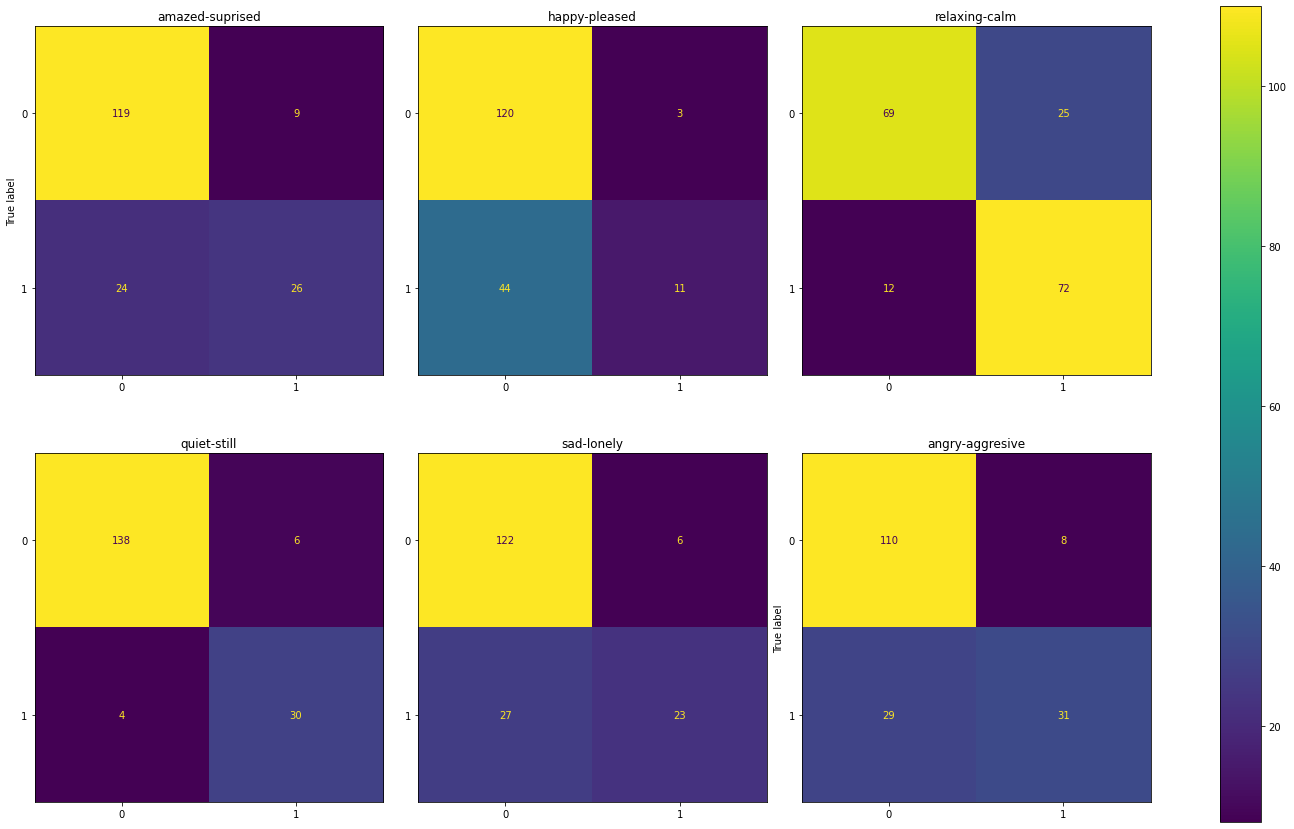

In [10]:
binclf = BinaryRelevanceClassifier(base_model=RandomForestClassifier())
binclf.fit(X_train,y_train)
y_pred_BR = binclf.predict(X_test) # Predictions on test data
 
# Matrix de confusion
acc_2 = get_accuracy_score(y_test,y_pred_BR) # Default accuracy score not used because it performs exact matching
print(" RandomForestClassifier Accuracy (hamming loss) of  = {:.6f} %".format(acc_2 * 100))
print('--------------------------------------------------------------------------------------------------------------')   
acc = accuracy_score(y_test,y_pred_BR)
print("RandomForestClassifier Accuracy of  = {:.6f} %".format(acc * 100))
f1 = round(f1_score(y_test,y_pred_BR, average = 'micro'),2)  
print("RandomForestClassifier F1 Score of  = {:.6f} %".format(f1 * 100))
print('--------------------------------------------------------------------------------------------------------------')   

print(classification_report(y_test,y_pred_BR))    
print('--------------------------------------------------------------------------------------------------------------')   

multilabel_confusion_matrix(y_test, y_pred_BR)
cm = metrics.multilabel_confusion_matrix(y_test, y_pred_BR)
#print(f'Confusion Matrix:\n{cm}')
#print(f'Confusion Matrix:\n{cm[1]}')

f, axes = plt.subplots(2, 3, figsize=(25, 15))
axes = axes.ravel()
for i in range(6):
    disp = ConfusionMatrixDisplay(cm[i])
    disp.plot(ax=axes[i], values_format='.4g')
    #disp.ax_.set_title(f'Label',labels[i])
    disp.ax_.set_title(labels[i])
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

In [11]:
y_pred_BR

array([[0., 1., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

# 1.2 GaussianNB

 GaussianNB Accuracy (hamming loss) of  = 52.247191 %
--------------------------------------------------------------------------------------------------------------
GaussianNB Accuracy of  = 20.786517 %
GaussianNB F1 Score of  = 63.000000 %
--------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.58      0.68      0.62        50
           1       0.47      0.55      0.50        55
           2       0.71      0.75      0.73        84
           3       0.53      0.91      0.67        34
           4       0.45      0.56      0.50        50
           5       0.58      0.85      0.69        60

   micro avg       0.56      0.71      0.63       333
   macro avg       0.55      0.72      0.62       333
weighted avg       0.57      0.71      0.63       333
 samples avg       0.56      0.71      0.59       333

---------------------------------------------------

C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


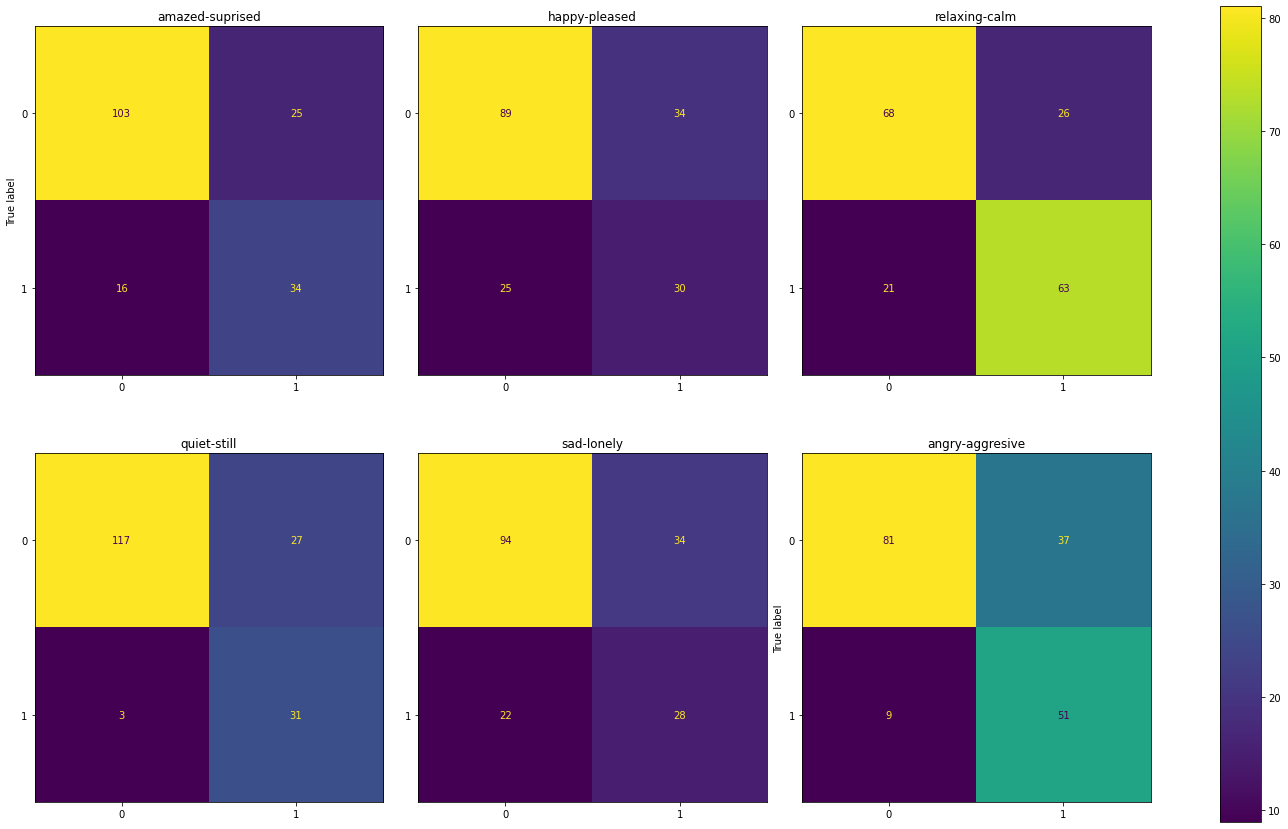

In [12]:
binclf = BinaryRelevanceClassifier(base_model=GaussianNB())
binclf.fit(X_train,y_train)
y_pred_BR = binclf.predict(X_test) # Predictions on test data
 
# Matrix de confusion
acc_2 = get_accuracy_score(y_test,y_pred_BR) # Default accuracy score not used because it performs exact matching
print(" GaussianNB Accuracy (hamming loss) of  = {:.6f} %".format(acc_2 * 100))
print('--------------------------------------------------------------------------------------------------------------')   
acc = accuracy_score(y_test,y_pred_BR)
print("GaussianNB Accuracy of  = {:.6f} %".format(acc * 100))
f1 = round(f1_score(y_test,y_pred_BR, average = 'micro'),2)  
print("GaussianNB F1 Score of  = {:.6f} %".format(f1 * 100))
print('--------------------------------------------------------------------------------------------------------------')   

print(classification_report(y_test,y_pred_BR))    
print('--------------------------------------------------------------------------------------------------------------')   

multilabel_confusion_matrix(y_test, y_pred_BR)
cm = metrics.multilabel_confusion_matrix(y_test, y_pred_BR)
#print(f'Confusion Matrix:\n{cm}')
#print(f'Confusion Matrix:\n{cm[1]}')

f, axes = plt.subplots(2, 3, figsize=(25, 15))
axes = axes.ravel()
for i in range(6):
    disp = ConfusionMatrixDisplay(cm[i])
    disp.plot(ax=axes[i], values_format='.4g')
    #disp.ax_.set_title(f'Label',labels[i])
    disp.ax_.set_title(labels[i])
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

# 1.3 DecisionTreeClassifier

 DecisionTreeClassifier Accuracy (hamming loss) of  = 48.876404 %
--------------------------------------------------------------------------------------------------------------
DecisionTreeClassifier Accuracy of  = 20.786517 %
DecisionTreeClassifier F1 Score of  = 62.000000 %
--------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.50      0.44      0.47        50
           1       0.49      0.45      0.47        55
           2       0.73      0.79      0.76        84
           3       0.67      0.85      0.75        34
           4       0.60      0.54      0.57        50
           5       0.59      0.62      0.60        60

   micro avg       0.61      0.62      0.62       333
   macro avg       0.60      0.61      0.60       333
weighted avg       0.61      0.62      0.61       333
 samples avg       0.56      0.61      0.55       333

---------------

C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


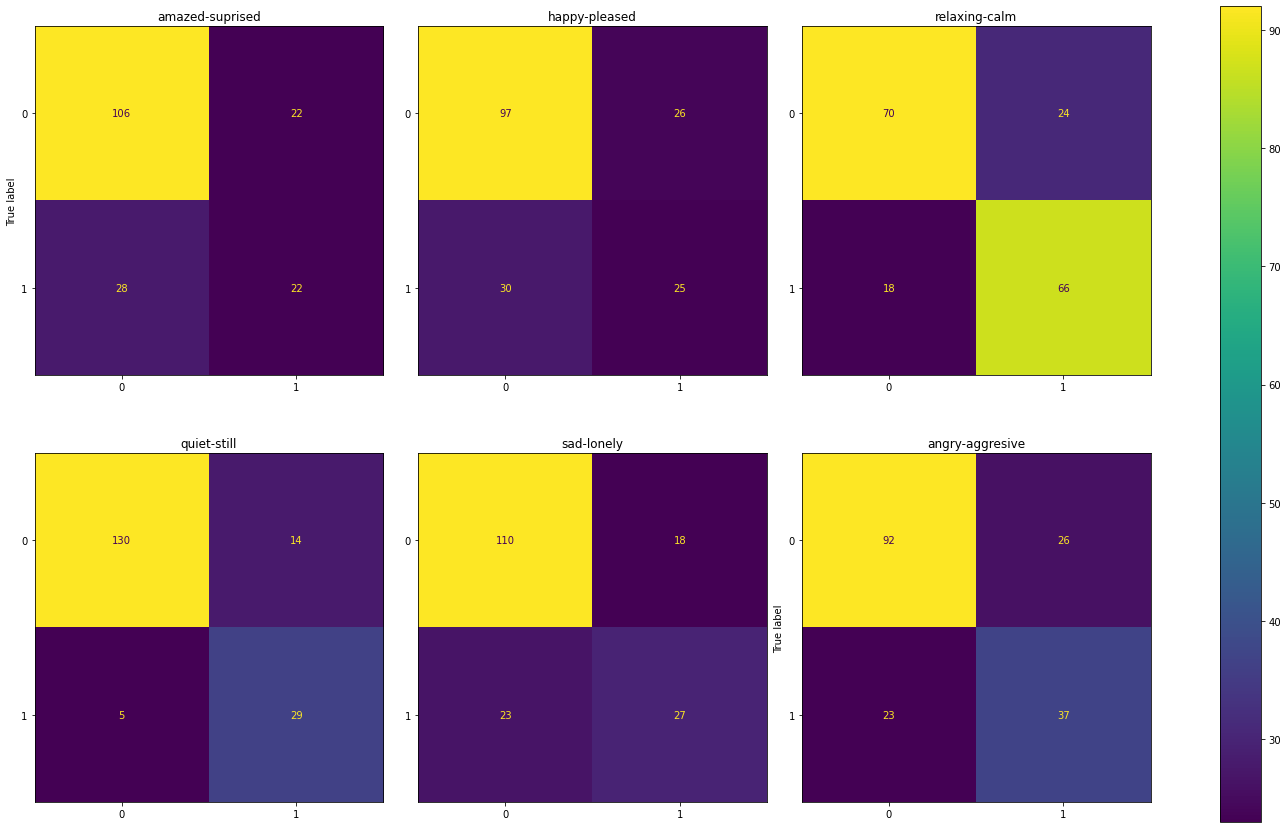

In [13]:
binclf = BinaryRelevanceClassifier(base_model=DecisionTreeClassifier())
binclf.fit(X_train,y_train)
y_pred_BR = binclf.predict(X_test) # Predictions on test data
 
# Matrix de confusion
acc_2 = get_accuracy_score(y_test,y_pred_BR) # Default accuracy score not used because it performs exact matching
print(" DecisionTreeClassifier Accuracy (hamming loss) of  = {:.6f} %".format(acc_2 * 100))
print('--------------------------------------------------------------------------------------------------------------')   
acc = accuracy_score(y_test,y_pred_BR)
print("DecisionTreeClassifier Accuracy of  = {:.6f} %".format(acc * 100))
f1 = round(f1_score(y_test,y_pred_BR, average = 'micro'),2)  
print("DecisionTreeClassifier F1 Score of  = {:.6f} %".format(f1 * 100))
print('--------------------------------------------------------------------------------------------------------------')   

print(classification_report(y_test,y_pred_BR))    
print('--------------------------------------------------------------------------------------------------------------')   

multilabel_confusion_matrix(y_test, y_pred_BR)
cm = metrics.multilabel_confusion_matrix(y_test, y_pred_BR)
#print(f'Confusion Matrix:\n{cm}')
#print(f'Confusion Matrix:\n{cm[1]}')

f, axes = plt.subplots(2, 3, figsize=(25, 15))
axes = axes.ravel()
for i in range(6):
    disp = ConfusionMatrixDisplay(cm[i])
    disp.plot(ax=axes[i], values_format='.4g')
    #disp.ax_.set_title(f'Label',labels[i])
    disp.ax_.set_title(labels[i])
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

# 1.4 Support vector machine

 svm Accuracy (hamming loss) of  = 66.853933 %
--------------------------------------------------------------------------------------------------------------
svm Accuracy of  = 27.528090 %
svm F1 Score of  = 66.000000 %
--------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.63      0.58      0.60        50
           1       0.50      0.18      0.27        55
           2       0.72      0.73      0.72        84
           3       0.76      0.85      0.81        34
           4       0.84      0.52      0.64        50
           5       0.84      0.72      0.77        60

   micro avg       0.73      0.59      0.66       333
   macro avg       0.72      0.60      0.64       333
weighted avg       0.71      0.59      0.64       333
 samples avg       0.66      0.60      0.60       333

------------------------------------------------------------------------

C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


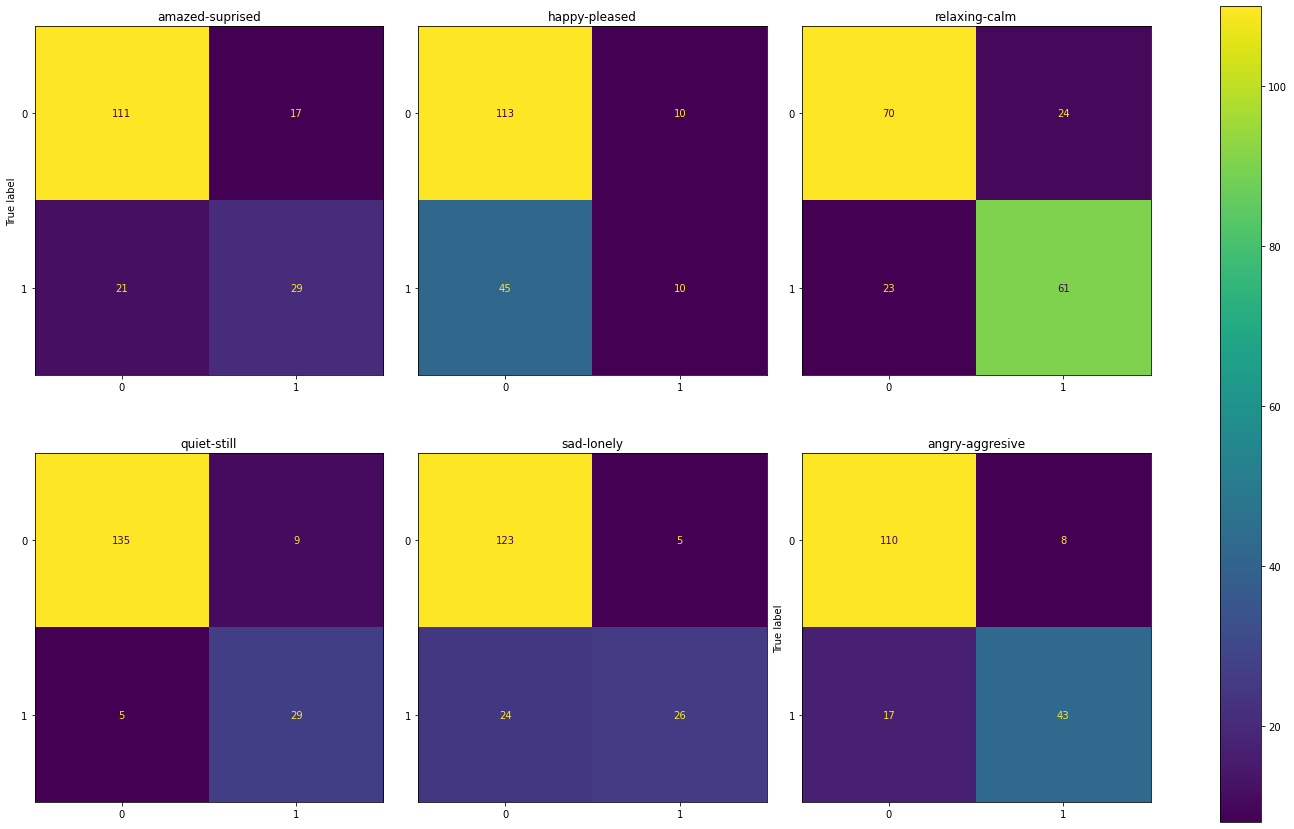

In [15]:
from sklearn import svm

binclf = BinaryRelevanceClassifier(base_model=svm.SVC(kernel='linear', C = 1.0))
binclf.fit(X_train,y_train)
y_pred_BR = binclf.predict(X_test) # Predictions on test data
 
# Matrix de confusion
acc_2 = get_accuracy_score(y_test,y_pred_BR) # Default accuracy score not used because it performs exact matching
print(" svm Accuracy (hamming loss) of  = {:.6f} %".format(acc_2 * 100))
print('--------------------------------------------------------------------------------------------------------------')   
acc = accuracy_score(y_test,y_pred_BR)
print("svm Accuracy of  = {:.6f} %".format(acc * 100))
f1 = round(f1_score(y_test,y_pred_BR, average = 'micro'),2)  
print("svm F1 Score of  = {:.6f} %".format(f1 * 100))
print('--------------------------------------------------------------------------------------------------------------')   

print(classification_report(y_test,y_pred_BR))    
print('--------------------------------------------------------------------------------------------------------------')   

multilabel_confusion_matrix(y_test, y_pred_BR)
cm = metrics.multilabel_confusion_matrix(y_test, y_pred_BR)
#print(f'Confusion Matrix:\n{cm}')
#print(f'Confusion Matrix:\n{cm[1]}')

f, axes = plt.subplots(2, 3, figsize=(25, 15))
axes = axes.ravel()
for i in range(6):
    disp = ConfusionMatrixDisplay(cm[i])
    disp.plot(ax=axes[i], values_format='.4g')
    #disp.ax_.set_title(f'Label',labels[i])
    disp.ax_.set_title(labels[i])
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

# 1.5 ExtraTreesClassifier

 ExtraTreesClassifier Accuracy (hamming loss) of  = 69.101124 %
--------------------------------------------------------------------------------------------------------------
ExtraTreesClassifier Accuracy of  = 30.898876 %
ExtraTreesClassifier F1 Score of  = 67.000000 %
--------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.72      0.52      0.60        50
           1       0.67      0.22      0.33        55
           2       0.74      0.87      0.80        84
           3       0.81      0.88      0.85        34
           4       0.88      0.44      0.59        50
           5       0.85      0.57      0.68        60

   micro avg       0.78      0.59      0.67       333
   macro avg       0.78      0.58      0.64       333
weighted avg       0.77      0.59      0.64       333
 samples avg       0.67      0.59      0.60       333

---------------------

C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


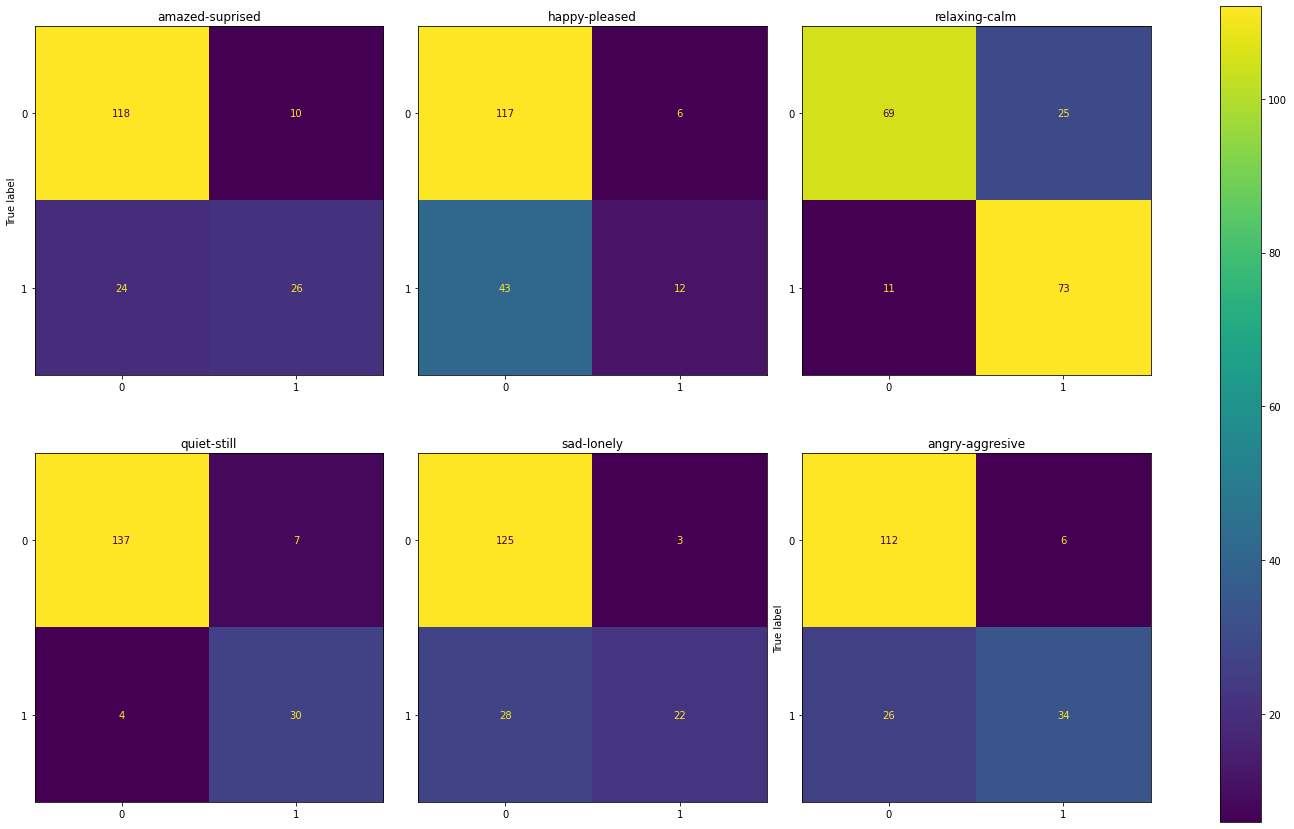

In [16]:
# 
binclf = BinaryRelevanceClassifier(base_model=ExtraTreesClassifier())
binclf.fit(X_train,y_train)
y_pred_BR = binclf.predict(X_test) # Predictions on test data
 
# Matrix de confusion
acc_2 = get_accuracy_score(y_test,y_pred_BR) # Default accuracy score not used because it performs exact matching
print(" ExtraTreesClassifier Accuracy (hamming loss) of  = {:.6f} %".format(acc_2 * 100))
print('--------------------------------------------------------------------------------------------------------------')   
acc = accuracy_score(y_test,y_pred_BR)
print("ExtraTreesClassifier Accuracy of  = {:.6f} %".format(acc * 100))
f1 = round(f1_score(y_test,y_pred_BR, average = 'micro'),2)  
print("ExtraTreesClassifier F1 Score of  = {:.6f} %".format(f1 * 100))
print('--------------------------------------------------------------------------------------------------------------')   

print(classification_report(y_test,y_pred_BR))    
print('--------------------------------------------------------------------------------------------------------------')   

multilabel_confusion_matrix(y_test, y_pred_BR)
cm = metrics.multilabel_confusion_matrix(y_test, y_pred_BR)
#print(f'Confusion Matrix:\n{cm}')
#print(f'Confusion Matrix:\n{cm[1]}')

f, axes = plt.subplots(2, 3, figsize=(25, 15))
axes = axes.ravel()
for i in range(6):
    disp = ConfusionMatrixDisplay(cm[i])
    disp.plot(ax=axes[i], values_format='.4g')
    #disp.ax_.set_title(f'Label',labels[i])
    disp.ax_.set_title(labels[i])
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

# 1.6 AdaBoostClassifier

 AdaBoostClassifier Accuracy (hamming loss) of  = 55.056180 %
--------------------------------------------------------------------------------------------------------------
AdaBoostClassifier Accuracy of  = 20.786517 %
AdaBoostClassifier F1 Score of  = 62.000000 %
--------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.57      0.50      0.53        50
           1       0.41      0.36      0.38        55
           2       0.71      0.79      0.75        84
           3       0.74      0.82      0.78        34
           4       0.62      0.52      0.57        50
           5       0.71      0.62      0.66        60

   micro avg       0.64      0.61      0.62       333
   macro avg       0.63      0.60      0.61       333
weighted avg       0.63      0.61      0.61       333
 samples avg       0.60      0.62      0.58       333

---------------------------

C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


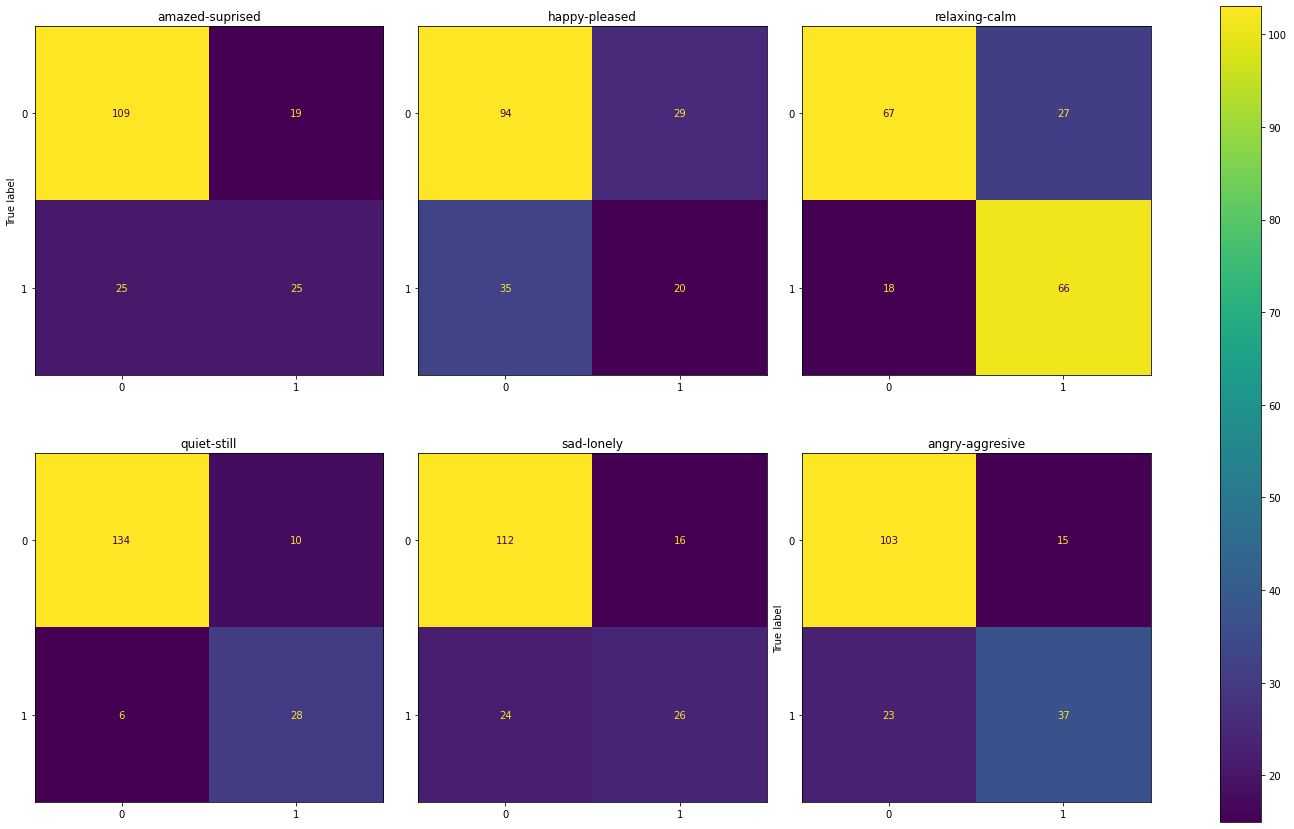

In [17]:

binclf = BinaryRelevanceClassifier(base_model=AdaBoostClassifier())
binclf.fit(X_train,y_train)
y_pred_BR = binclf.predict(X_test) # Predictions on test data
 
# Matrix de confusion
acc_2 = get_accuracy_score(y_test,y_pred_BR) # Default accuracy score not used because it performs exact matching
print(" AdaBoostClassifier Accuracy (hamming loss) of  = {:.6f} %".format(acc_2 * 100))
print('--------------------------------------------------------------------------------------------------------------')   
acc = accuracy_score(y_test,y_pred_BR)
print("AdaBoostClassifier Accuracy of  = {:.6f} %".format(acc * 100))
f1 = round(f1_score(y_test,y_pred_BR, average = 'micro'),2)  
print("AdaBoostClassifier F1 Score of  = {:.6f} %".format(f1 * 100))
print('--------------------------------------------------------------------------------------------------------------')   

print(classification_report(y_test,y_pred_BR))    
print('--------------------------------------------------------------------------------------------------------------')   

multilabel_confusion_matrix(y_test, y_pred_BR)
cm = metrics.multilabel_confusion_matrix(y_test, y_pred_BR)
#print(f'Confusion Matrix:\n{cm}')
#print(f'Confusion Matrix:\n{cm[1]}')

f, axes = plt.subplots(2, 3, figsize=(25, 15))
axes = axes.ravel()
for i in range(6):
    disp = ConfusionMatrixDisplay(cm[i])
    disp.plot(ax=axes[i], values_format='.4g')
    #disp.ax_.set_title(f'Label',labels[i])
    disp.ax_.set_title(labels[i])
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

## Task 2: Implement the Classifier Chains Algorithm

In [18]:
class ClassifierChains(BaseEstimator, ClassifierMixin):
    
    def __init__(self, base_model=LogisticRegression(), order = None, undersample=False):
        self.base_model = base_model # The base estimator
        self.order = order # Order of labels in which the labels are to be sent to the classifier
        self.undersample = undersample # Whether or not to undersample
        
    def fit(self, X, y):
        X_cpy = X.copy()
        y_cpy = y.copy()
        self.order_shuffle = None
        self.base_order = list(range(len(y.columns)))
        
        if self.order is None:
            self.order_shuffle = list(range(len(y_cpy.columns))) # Same order as input
            
        elif self.order == 'random':
            self.order_shuffle = list(range(len(y_cpy.columns))) # Random label order
            random.shuffle(self.order_shuffle)
            print(self.order_shuffle)
            
        else:
            if len(self.order) == len(y.columns) and all(isinstance(item, int) for item in self.order):
                self.order_shuffle = self.order # Label order given by user
        
        y_cpy = y_cpy.iloc[:,self.order_shuffle] # Shuffle y according to label order
        
        
        self.model_list_ = []
        for column in y_cpy:
            X_cpy.reset_index(drop=True, inplace=True)
            y_cpy.reset_index(drop=True, inplace=True)
            
            X_copy = X_cpy.copy()
            
            if self.undersample:
                concat_x_y = X_copy.join(y_cpy[column]) #Concat X and the label to perform undersampling
                label_0, label_1 = sum(y_cpy[column]==0), sum(y_cpy[column])

                ratio = label_1/label_0 #Check the ratio of 1s to 0s in a target

                '''Here, we undersample only when the difference between 1 and 0 is quite large, 
                that is if the number of the majority class is more than double the number of the minority class'''

                if ratio < 0.5: # Undersample using pd.sample on label 0
                    xy_label_1 = concat_x_y[concat_x_y[column]==1]
                    xy_label_0 = concat_x_y[concat_x_y[column]==0].sample(label_1)
                    concat_x_y = pd.concat([xy_label_0, xy_label_1], axis=0)

                elif ratio >= 2: # Undersample using pd.sample on label 1
                    xy_label_1 = concat_x_y[concat_x_y[column]==1].sample(label_0) 
                    xy_label_0 = concat_x_y[concat_x_y[column]==0]
                    concat_x_y = pd.concat([xy_label_0, xy_label_1], axis=0)              

                #Separate concatenated dataset into X and y
                X_copy = concat_x_y.iloc[:,:-1]
                y_column = concat_x_y.iloc[:,-1]

            else:
                y_column = y_cpy[column]
                
            clf = clone(self.base_model)
            A,b = check_X_y(X_copy, y_column)
            clf.fit(A,b)  # Fit model to the (undersampled if true) dataset
            self.model_list_.append(clf)   # Append model to list
            y_col = pd.DataFrame(y_cpy[column])
            X_cpy = pd.concat([X_cpy, y_col], axis=1)  # Concatenate current label to X
            
            
    def predict(self,X):
        X_cpy = X.copy()
        X_cpy.reset_index(drop=True, inplace=True)
        check_is_fitted(self, ['model_list_']) # Check if the model list is present
        y_pred = pd.DataFrame() # Create a dataframe to save predictions
        i = 0
        for model in self.model_list_: # Make predictions for each label, using the corresponding mdodel
            X_cpy = check_array(X_cpy)
            y_pred_class = model.predict(X_cpy) # Predict current label
            y_pred[self.order_shuffle[i]] = y_pred_class # Save the predicted class according to our label order
            
            X_cpy = np.column_stack((X_cpy, y_pred_class)) # Append the predicted column to X test
            i+=1
            
        y_pred = y_pred.loc[:,self.base_order] # Return according to original order
        return y_pred.to_numpy() # Return as numpy array
    
    def predict_proba(self,X):
        X_cpy = X.copy()
        X_cpy.reset_index(drop=True, inplace=True)
        check_is_fitted(self, ['model_list_']) #Check if the model list is present
        y_pred = pd.DataFrame() # Create a dataframe to save predictions
        i = 0
        for model in self.model_list_: # Make prediction probabilities for each label, using the corresponding mdodel
            X_cpy = check_array(X_cpy)
            y_pred_class = model.predict(X_cpy) # Predict current label
            y_pred_class_proba = model.predict_proba(X_cpy) # Predict probabilties using current model
            y_pred[self.order_shuffle[i]] = [one_prob[1] for one_prob in y_pred_class_proba] # Save the probabilities of 1 according to our label order
            X_cpy = np.column_stack((X_cpy, y_pred_class)) # Append prediction to X test
            i+=1
        y_pred = y_pred.loc[:,self.base_order] # Return probabilities according to original order
        return y_pred.to_numpy() # Return as numpy

# 2.1 RandomForestClassifier

 RandomForestClassifier Accuracy (hamming loss) of  = 68.539326 %
--------------------------------------------------------------------------------------------------------------
RandomForestClassifier Accuracy of  = 29.775281 %
RandomForestClassifier F1 Score of  = 66.000000 %
--------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.72      0.46      0.56        50
           1       0.73      0.20      0.31        55
           2       0.73      0.87      0.79        84
           3       0.76      0.85      0.81        34
           4       0.71      0.48      0.57        50
           5       0.76      0.65      0.70        60

   micro avg       0.74      0.60      0.66       333
   macro avg       0.74      0.59      0.62       333
weighted avg       0.73      0.60      0.63       333
 samples avg       0.70      0.60      0.61       333

---------------

C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


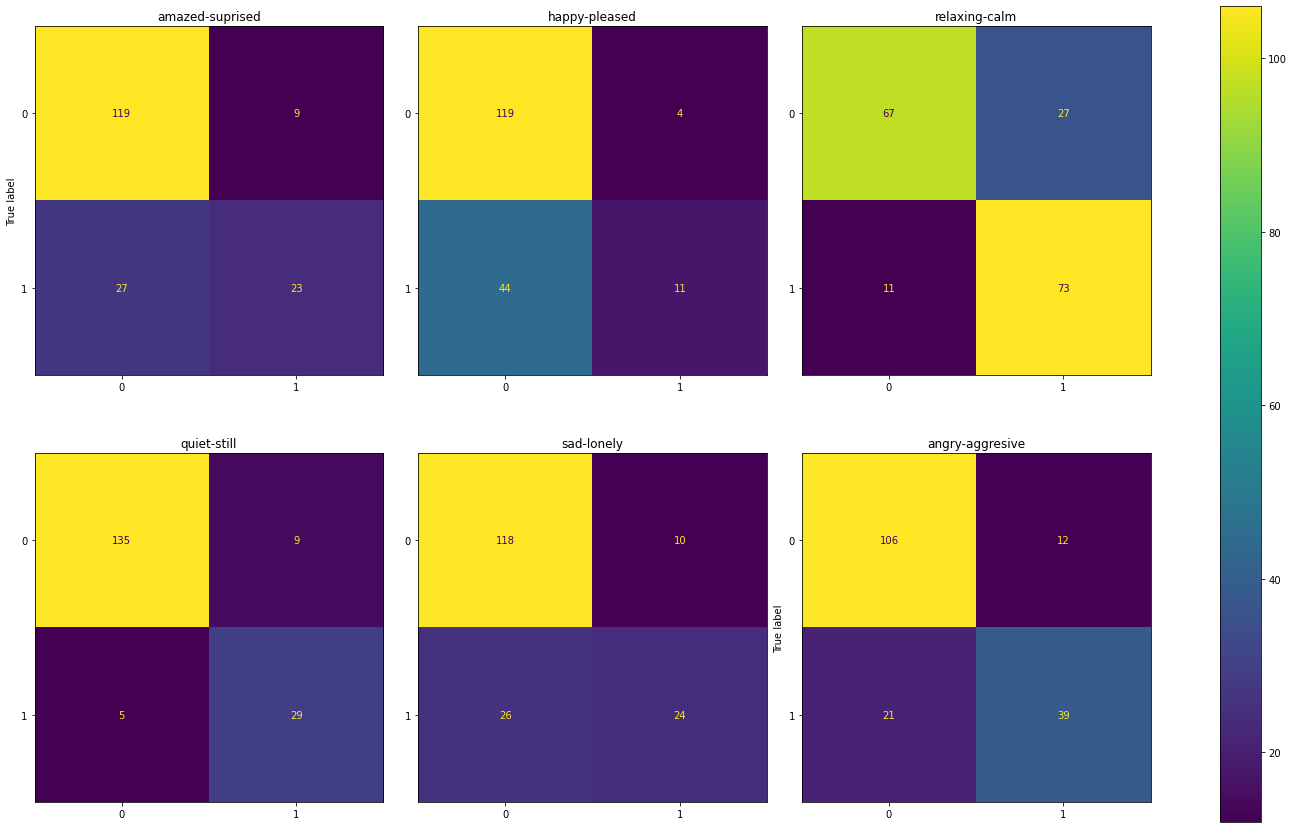

In [19]:

class_chain = ClassifierChains(base_model=RandomForestClassifier())
class_chain.fit(X_train,y_train)

y_pred_cc = class_chain.predict(X_test) # Predictions on test data
 
# Matrix de confusion
acc_2 = get_accuracy_score(y_test,y_pred_cc) # Default accuracy score not used because it performs exact matching
print(" RandomForestClassifier Accuracy (hamming loss) of  = {:.6f} %".format(acc_2 * 100))
print('--------------------------------------------------------------------------------------------------------------')   
acc = accuracy_score(y_test,y_pred_cc)
print("RandomForestClassifier Accuracy of  = {:.6f} %".format(acc * 100))
f1 = round(f1_score(y_test,y_pred_cc, average = 'micro'),2)  
print("RandomForestClassifier F1 Score of  = {:.6f} %".format(f1 * 100))
print('--------------------------------------------------------------------------------------------------------------')   

print(classification_report(y_test,y_pred_cc))    
print('--------------------------------------------------------------------------------------------------------------')   

multilabel_confusion_matrix(y_test, y_pred_cc)
cm = metrics.multilabel_confusion_matrix(y_test, y_pred_cc)
#print(f'Confusion Matrix:\n{cm}')
#print(f'Confusion Matrix:\n{cm[1]}')

f, axes = plt.subplots(2, 3, figsize=(25, 15))
axes = axes.ravel()
for i in range(6):
    disp = ConfusionMatrixDisplay(cm[i])
    disp.plot(ax=axes[i], values_format='.4g')
    #disp.ax_.set_title(f'Label',labels[i])
    disp.ax_.set_title(labels[i])
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

# 2.2 GaussianNB

 GaussianNB Accuracy (hamming loss) of  = 60.674157 %
--------------------------------------------------------------------------------------------------------------
GaussianNB Accuracy of  = 19.662921 %
GaussianNB F1 Score of  = 66.000000 %
--------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.58      0.68      0.62        50
           1       0.48      0.56      0.52        55
           2       0.71      0.79      0.75        84
           3       0.53      0.91      0.67        34
           4       0.63      0.54      0.58        50
           5       0.64      0.83      0.72        60

   micro avg       0.60      0.72      0.66       333
   macro avg       0.59      0.72      0.64       333
weighted avg       0.61      0.72      0.65       333
 samples avg       0.59      0.72      0.62       333

---------------------------------------------------

C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


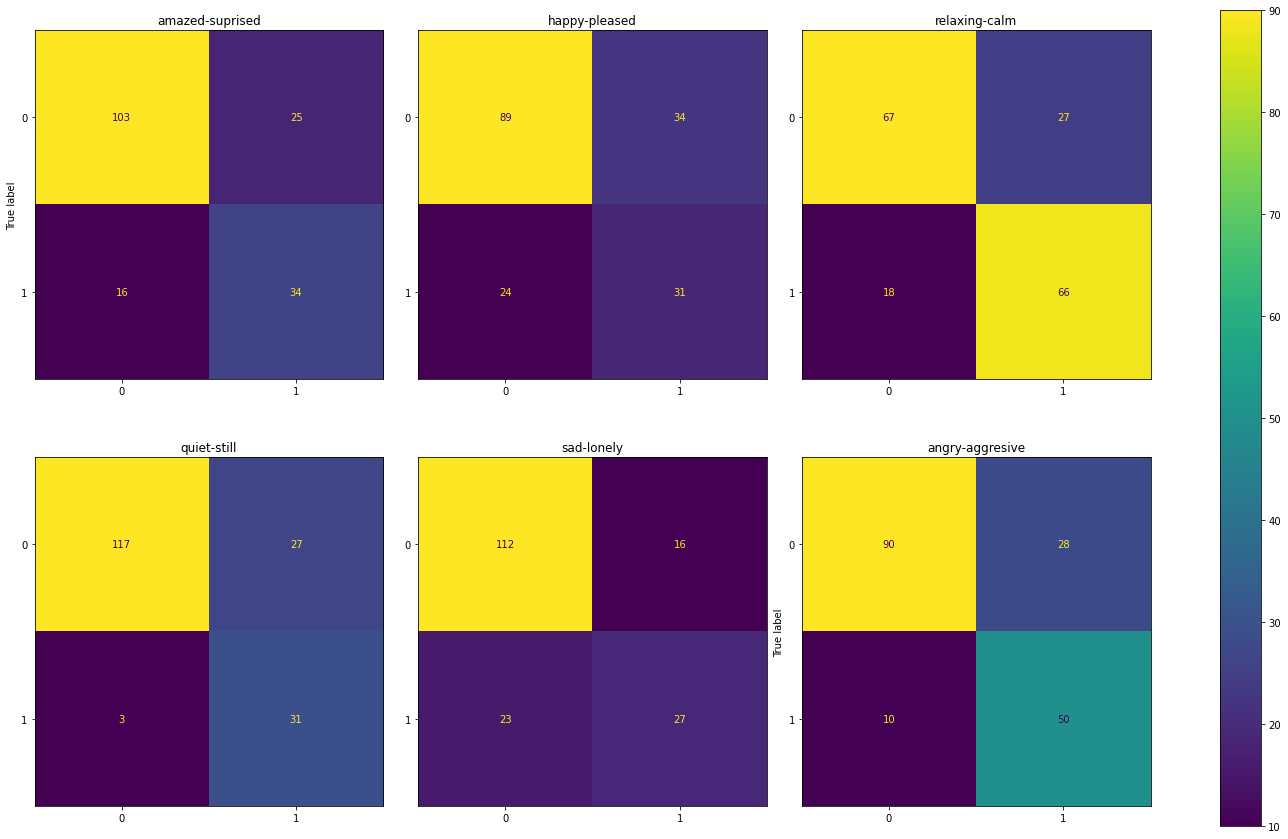

In [20]:
class_chain = ClassifierChains(base_model=GaussianNB())
class_chain.fit(X_train,y_train)
y_pred_cc = class_chain.predict(X_test) # Predictions on test data

# Matrix de confusion
acc_2 = get_accuracy_score(y_test,y_pred_cc) # Default accuracy score not used because it performs exact matching
print(" GaussianNB Accuracy (hamming loss) of  = {:.6f} %".format(acc_2 * 100))
print('--------------------------------------------------------------------------------------------------------------')   
acc = accuracy_score(y_test,y_pred_cc)
print("GaussianNB Accuracy of  = {:.6f} %".format(acc * 100))
f1 = round(f1_score(y_test,y_pred_cc, average = 'micro'),2)  
print("GaussianNB F1 Score of  = {:.6f} %".format(f1 * 100))
print('--------------------------------------------------------------------------------------------------------------')   

print(classification_report(y_test,y_pred_cc))    
print('--------------------------------------------------------------------------------------------------------------')   

multilabel_confusion_matrix(y_test, y_pred_cc)
cm = metrics.multilabel_confusion_matrix(y_test, y_pred_cc)
#print(f'Confusion Matrix:\n{cm}')
#print(f'Confusion Matrix:\n{cm[1]}')

f, axes = plt.subplots(2, 3, figsize=(25, 15))
axes = axes.ravel()
for i in range(6):
    disp = ConfusionMatrixDisplay(cm[i])
    disp.plot(ax=axes[i], values_format='.4g')
    #disp.ax_.set_title(f'Label',labels[i])
    disp.ax_.set_title(labels[i])
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()  

# 2.3 DecisionTreeClassifier

 DecisionTreeClassifier Accuracy (hamming loss) of  = 47.752809 %
--------------------------------------------------------------------------------------------------------------
DecisionTreeClassifier Accuracy of  = 17.415730 %
DecisionTreeClassifier F1 Score of  = 57.000000 %
--------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.44      0.38      0.41        50
           1       0.47      0.45      0.46        55
           2       0.70      0.76      0.73        84
           3       0.61      0.74      0.67        34
           4       0.46      0.52      0.49        50
           5       0.65      0.47      0.54        60

   micro avg       0.57      0.56      0.57       333
   macro avg       0.56      0.55      0.55       333
weighted avg       0.57      0.56      0.56       333
 samples avg       0.55      0.55      0.52       333

---------------

C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


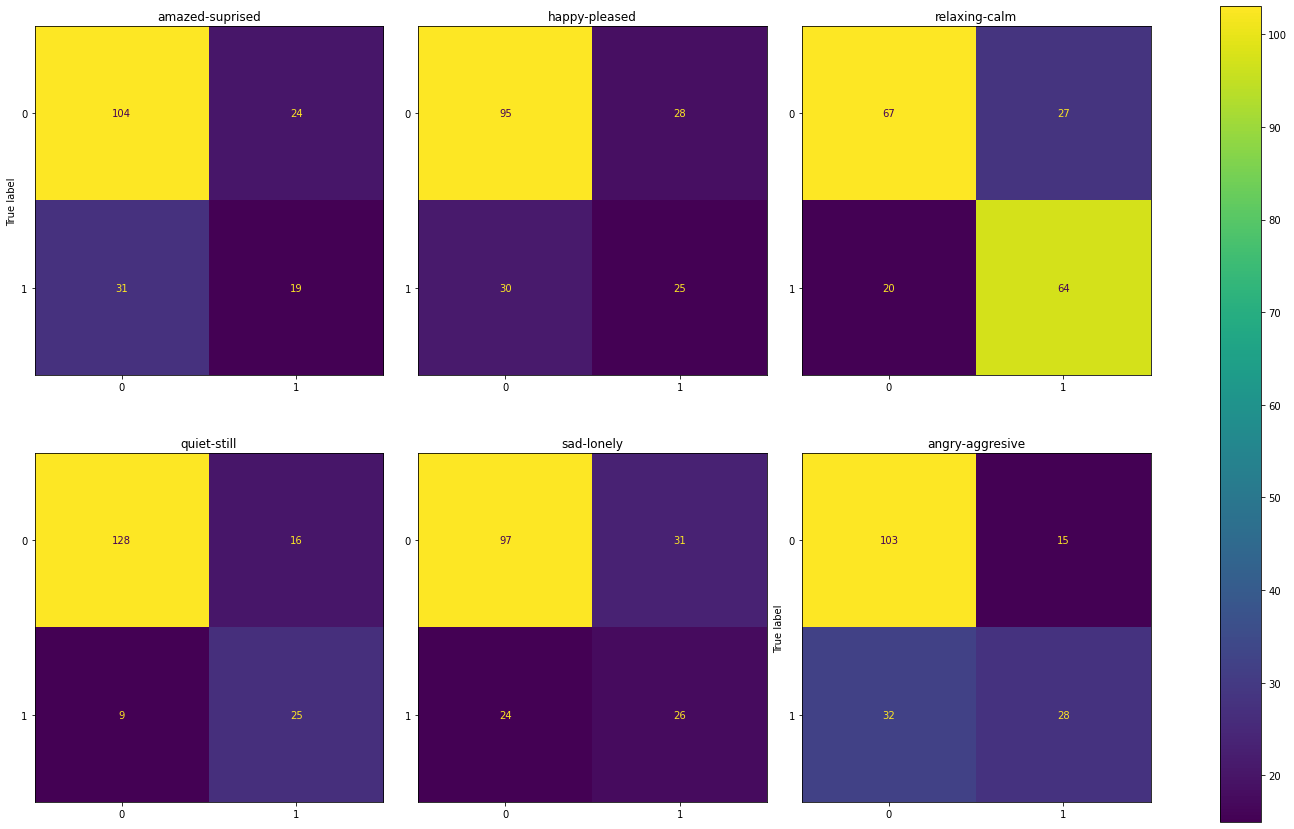

In [21]:
class_chain = ClassifierChains(base_model=DecisionTreeClassifier())
class_chain.fit(X_train,y_train)
y_pred_cc = class_chain.predict(X_test) # Predictions on test data

# Matrix de confusion
acc_2 = get_accuracy_score(y_test,y_pred_cc) # Default accuracy score not used because it performs exact matching
print(" DecisionTreeClassifier Accuracy (hamming loss) of  = {:.6f} %".format(acc_2 * 100))
print('--------------------------------------------------------------------------------------------------------------')   
acc = accuracy_score(y_test,y_pred_cc)
print("DecisionTreeClassifier Accuracy of  = {:.6f} %".format(acc * 100))
f1 = round(f1_score(y_test,y_pred_cc, average = 'micro'),2)  
print("DecisionTreeClassifier F1 Score of  = {:.6f} %".format(f1 * 100))
print('--------------------------------------------------------------------------------------------------------------')   

print(classification_report(y_test,y_pred_cc))    
print('--------------------------------------------------------------------------------------------------------------')   

multilabel_confusion_matrix(y_test, y_pred_cc)
cm = metrics.multilabel_confusion_matrix(y_test, y_pred_cc)
#print(f'Confusion Matrix:\n{cm}')
#print(f'Confusion Matrix:\n{cm[1]}')

f, axes = plt.subplots(2, 3, figsize=(25, 15))
axes = axes.ravel()
for i in range(6):
    disp = ConfusionMatrixDisplay(cm[i])
    disp.plot(ax=axes[i], values_format='.4g')
    #disp.ax_.set_title(f'Label',labels[i])
    disp.ax_.set_title(labels[i])
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()  

# 2.4 Support Vector Machine

 svm Accuracy (hamming loss) of  = 60.674157 %
--------------------------------------------------------------------------------------------------------------
svm Accuracy of  = 26.966292 %
svm F1 Score of  = 62.000000 %
--------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.63      0.58      0.60        50
           1       0.50      0.20      0.29        55
           2       0.69      0.70      0.69        84
           3       0.67      0.82      0.74        34
           4       0.66      0.54      0.59        50
           5       0.61      0.77      0.68        60

   micro avg       0.64      0.60      0.62       333
   macro avg       0.63      0.60      0.60       333
weighted avg       0.63      0.60      0.60       333
 samples avg       0.63      0.60      0.59       333

------------------------------------------------------------------------

C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


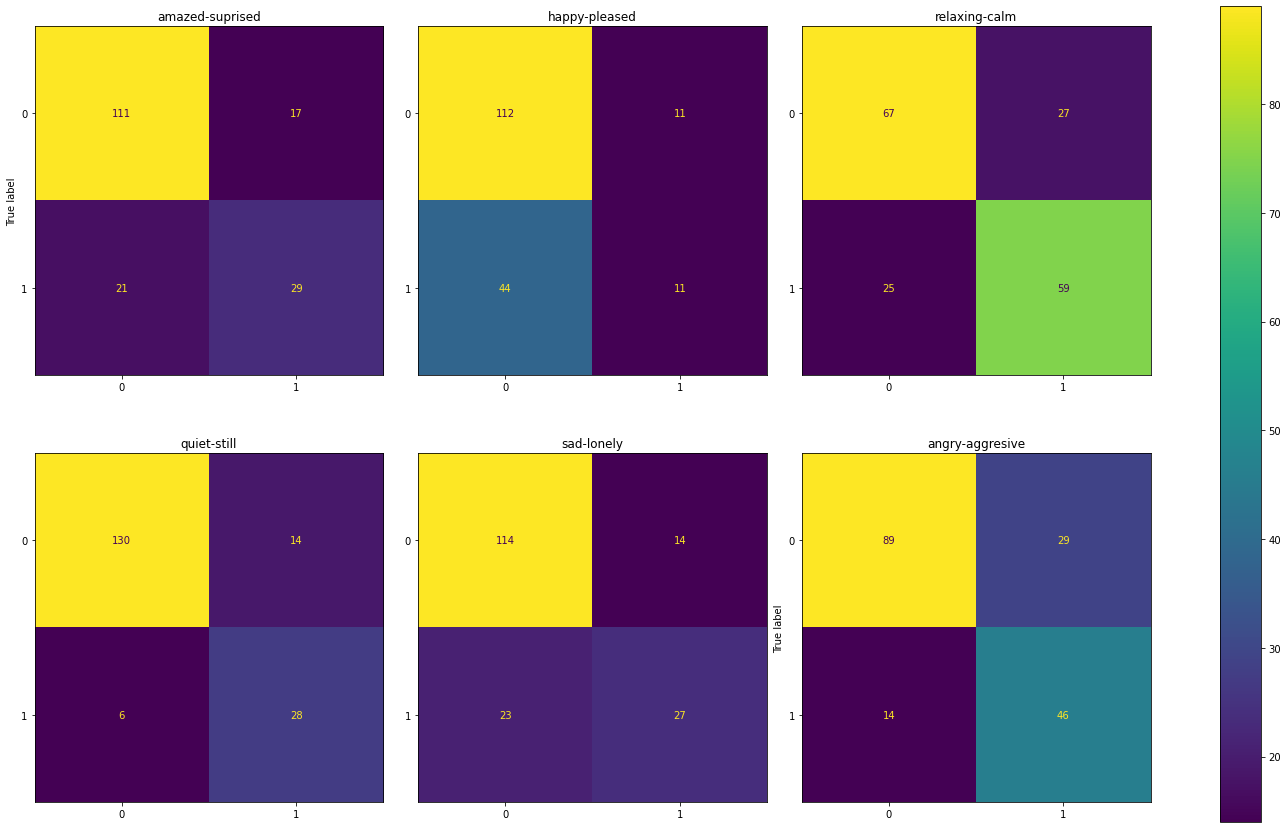

In [22]:
class_chain = ClassifierChains(base_model=svm.SVC(kernel='linear', C = 1.0))
class_chain.fit(X_train,y_train)
y_pred_cc = class_chain.predict(X_test) # Predictions on test data

# Matrix de confusion
acc_2 = get_accuracy_score(y_test,y_pred_cc) # Default accuracy score not used because it performs exact matching
print(" svm Accuracy (hamming loss) of  = {:.6f} %".format(acc_2 * 100))
print('--------------------------------------------------------------------------------------------------------------')   
acc = accuracy_score(y_test,y_pred_cc)
print("svm Accuracy of  = {:.6f} %".format(acc * 100))
f1 = round(f1_score(y_test,y_pred_cc, average = 'micro'),2)  
print("svm F1 Score of  = {:.6f} %".format(f1 * 100))
print('--------------------------------------------------------------------------------------------------------------')   

print(classification_report(y_test,y_pred_cc))    
print('--------------------------------------------------------------------------------------------------------------')   

multilabel_confusion_matrix(y_test, y_pred_cc)
cm = metrics.multilabel_confusion_matrix(y_test, y_pred_cc)
#print(f'Confusion Matrix:\n{cm}')
#print(f'Confusion Matrix:\n{cm[1]}')

f, axes = plt.subplots(2, 3, figsize=(25, 15))
axes = axes.ravel()
for i in range(6):
    disp = ConfusionMatrixDisplay(cm[i])
    disp.plot(ax=axes[i], values_format='.4g')
    #disp.ax_.set_title(f'Label',labels[i])
    disp.ax_.set_title(labels[i])
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()  

# 2.5 ExtraTreesClassifier

 ExtraTreesClassifier Accuracy (hamming loss) of  = 70.786517 %
--------------------------------------------------------------------------------------------------------------
ExtraTreesClassifier Accuracy of  = 35.393258 %
ExtraTreesClassifier F1 Score of  = 69.000000 %
--------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.68      0.50      0.57        50
           1       0.62      0.18      0.28        55
           2       0.77      0.89      0.83        84
           3       0.71      0.88      0.79        34
           4       0.76      0.56      0.64        50
           5       0.75      0.82      0.78        60

   micro avg       0.74      0.65      0.69       333
   macro avg       0.72      0.64      0.65       333
weighted avg       0.72      0.65      0.66       333
 samples avg       0.71      0.65      0.65       333

---------------------

C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


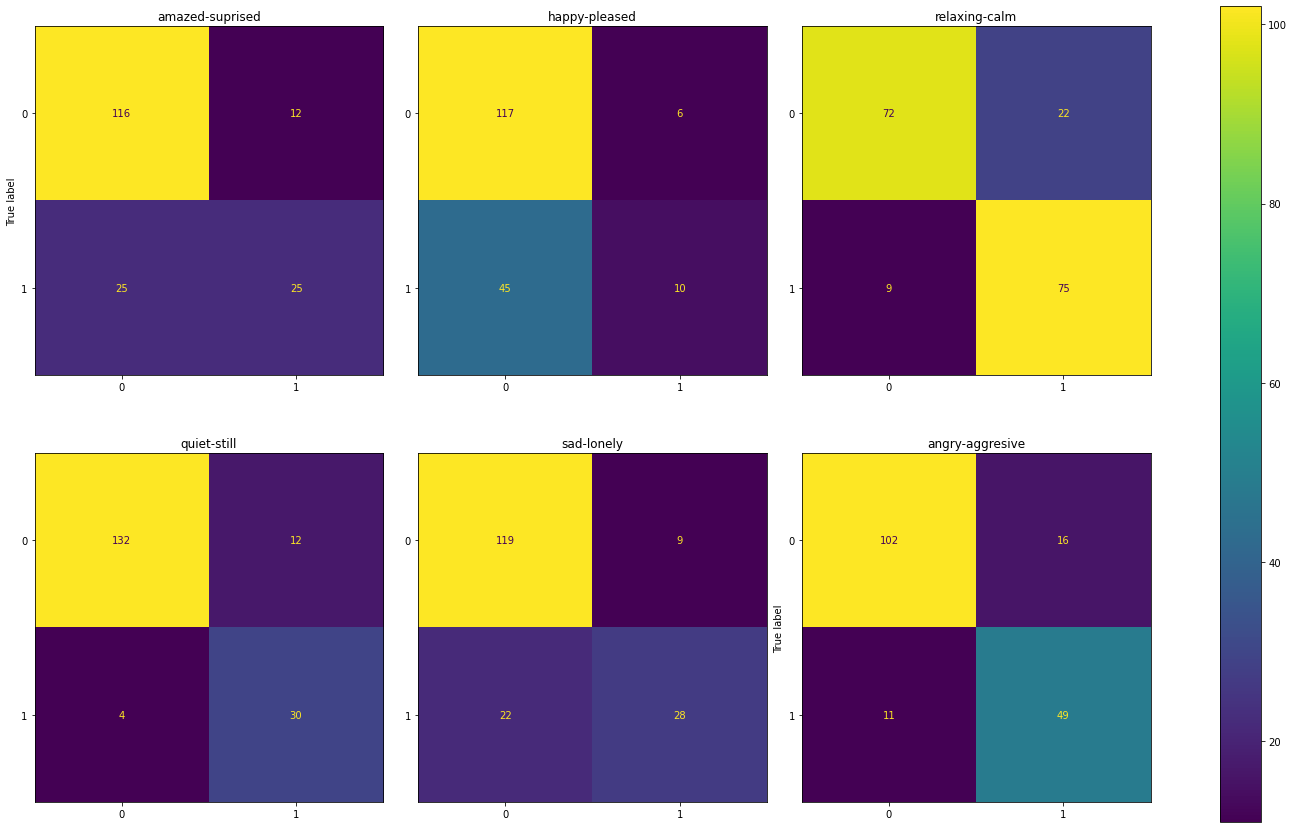

In [23]:
class_chain = ClassifierChains(base_model=ExtraTreesClassifier())
class_chain.fit(X_train,y_train)
y_pred_cc = class_chain.predict(X_test) # Predictions on test data

# Matrix de confusion
acc_2 = get_accuracy_score(y_test,y_pred_cc) # Default accuracy score not used because it performs exact matching
print(" ExtraTreesClassifier Accuracy (hamming loss) of  = {:.6f} %".format(acc_2 * 100))
print('--------------------------------------------------------------------------------------------------------------')   
acc = accuracy_score(y_test,y_pred_cc)
print("ExtraTreesClassifier Accuracy of  = {:.6f} %".format(acc * 100))
f1 = round(f1_score(y_test,y_pred_cc, average = 'micro'),2)  
print("ExtraTreesClassifier F1 Score of  = {:.6f} %".format(f1 * 100))
print('--------------------------------------------------------------------------------------------------------------')   

print(classification_report(y_test,y_pred_cc))    
print('--------------------------------------------------------------------------------------------------------------')   

multilabel_confusion_matrix(y_test, y_pred_cc)
cm = metrics.multilabel_confusion_matrix(y_test, y_pred_cc)
#print(f'Confusion Matrix:\n{cm}')
#print(f'Confusion Matrix:\n{cm[1]}')

f, axes = plt.subplots(2, 3, figsize=(25, 15))
axes = axes.ravel()
for i in range(6):
    disp = ConfusionMatrixDisplay(cm[i])
    disp.plot(ax=axes[i], values_format='.4g')
    #disp.ax_.set_title(f'Label',labels[i])
    disp.ax_.set_title(labels[i])
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()  

# 2.6 AdaBoostClassifier

 AdaBoostClassifier Accuracy (hamming loss) of  = 60.112360 %
--------------------------------------------------------------------------------------------------------------
AdaBoostClassifier Accuracy of  = 23.595506 %
AdaBoostClassifier F1 Score of  = 63.000000 %
--------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.57      0.50      0.53        50
           1       0.41      0.36      0.38        55
           2       0.75      0.82      0.78        84
           3       0.71      0.88      0.79        34
           4       0.59      0.52      0.55        50
           5       0.73      0.60      0.66        60

   micro avg       0.64      0.62      0.63       333
   macro avg       0.63      0.61      0.62       333
weighted avg       0.64      0.62      0.62       333
 samples avg       0.62      0.62      0.59       333

---------------------------

C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


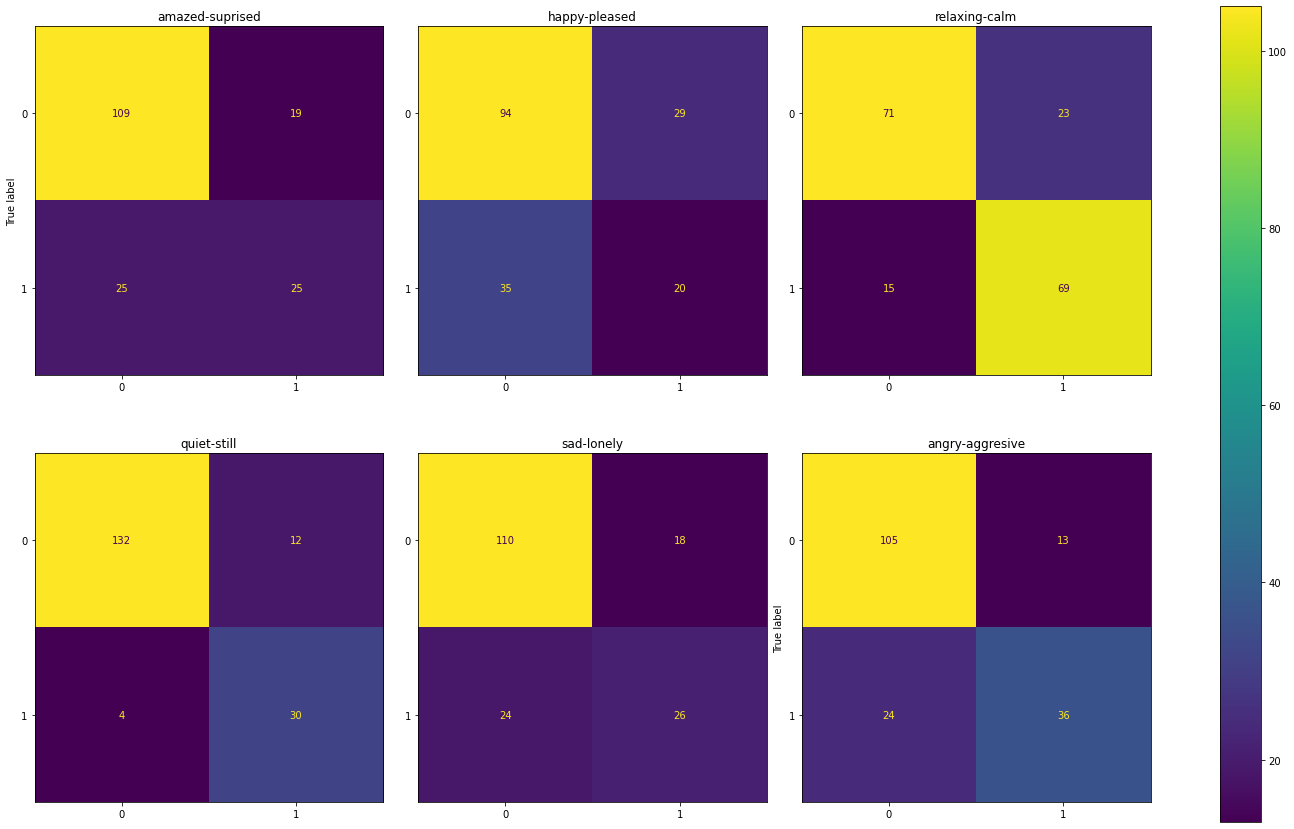

In [24]:
class_chain = ClassifierChains(base_model=AdaBoostClassifier())
class_chain.fit(X_train,y_train)
y_pred_cc = class_chain.predict(X_test) # Predictions on test data

# Matrix de confusion
acc_2 = get_accuracy_score(y_test,y_pred_cc) # Default accuracy score not used because it performs exact matching
print(" AdaBoostClassifier Accuracy (hamming loss) of  = {:.6f} %".format(acc_2 * 100))
print('--------------------------------------------------------------------------------------------------------------')   
acc = accuracy_score(y_test,y_pred_cc)
print("AdaBoostClassifier Accuracy of  = {:.6f} %".format(acc * 100))
f1 = round(f1_score(y_test,y_pred_cc, average = 'micro'),2)  
print("AdaBoostClassifier F1 Score of  = {:.6f} %".format(f1 * 100))
print('--------------------------------------------------------------------------------------------------------------')   

print(classification_report(y_test,y_pred_cc))    
print('--------------------------------------------------------------------------------------------------------------')   

multilabel_confusion_matrix(y_test, y_pred_cc)
cm = metrics.multilabel_confusion_matrix(y_test, y_pred_cc)
#print(f'Confusion Matrix:\n{cm}')
#print(f'Confusion Matrix:\n{cm[1]}')

f, axes = plt.subplots(2, 3, figsize=(25, 15))
axes = axes.ravel()
for i in range(6):
    disp = ConfusionMatrixDisplay(cm[i])
    disp.plot(ax=axes[i], values_format='.4g')
    #disp.ax_.set_title(f'Label',labels[i])
    disp.ax_.set_title(labels[i])
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()  

# Task 3: Implement the LabelPowerset Algorithm


# 3.1 AdaBoostClassifier

C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(
C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------------------------------------------------------
AdaBoostClassifier Accuracy of  = 17.977528 %
AdaBoostClassifier F1 Score of  = 44.000000 %
--------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        50
           1       0.00      0.00      0.00        55
           2       0.68      0.30      0.41        84
           3       0.68      0.74      0.70        34
           4       0.59      0.46      0.52        50
           5       0.41      0.95      0.57        60

   micro avg       0.51      0.39      0.44       333
   macro avg       0.39      0.41      0.37       333
weighted avg       0.40      0.39      0.36       333
 samples avg       0.46      0.39      0.39       333

-----------------------------------------------------------------------------------------

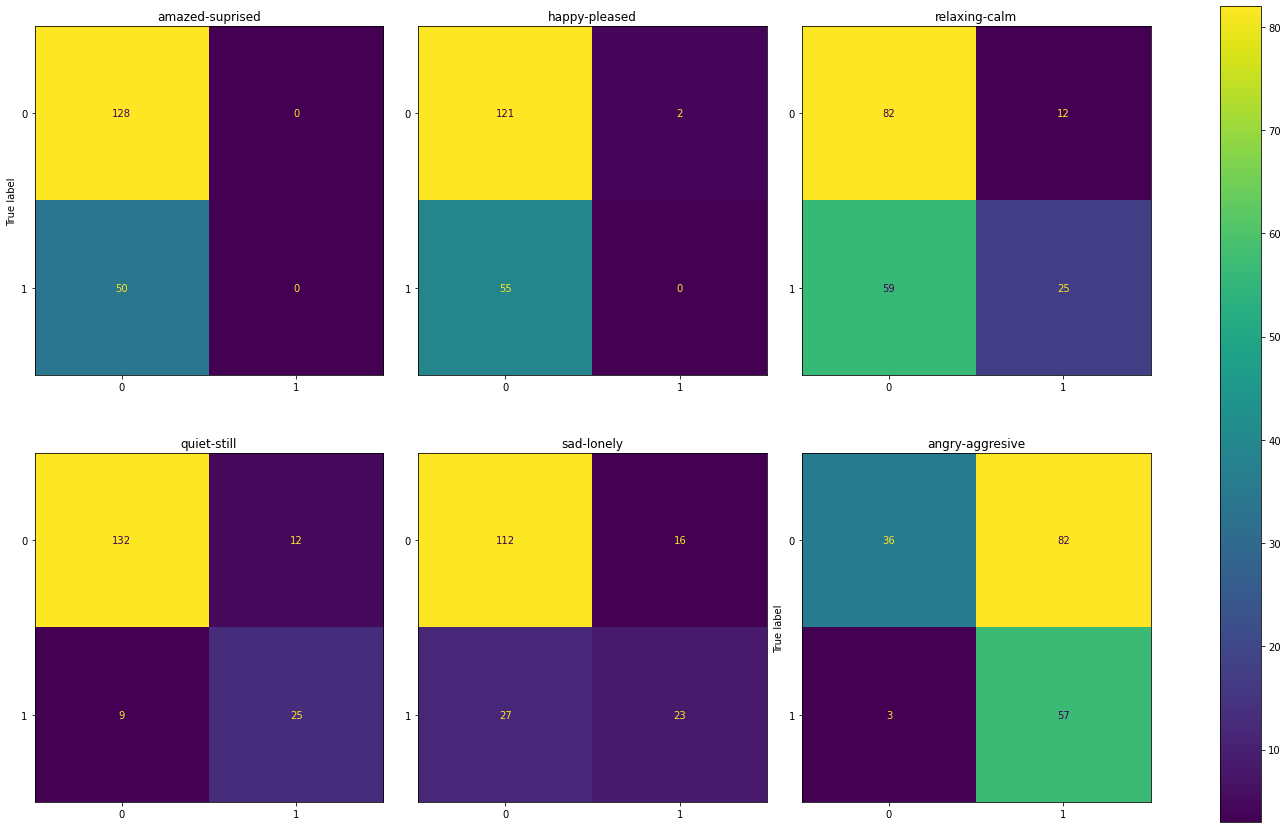

In [32]:
cla_LPowerset = LabelPowerset(AdaBoostClassifier())
cla_LPowerset.fit(X_train,y_train)
y_pred_LP = cla_LPowerset.predict(X_test) # Predictions on test data

# Matrix de confusion
#acc_2 = get_accuracy_score(y_test,y_pred_LP) # Default accuracy score not used because it performs exact matching
#print(" AdaBoostClassifier Accuracy (hamming loss) of  = {:.6f} %".format(acc_2 * 100))
print('--------------------------------------------------------------------------------------------------------------')   
acc = accuracy_score(y_test,y_pred_LP)
print("AdaBoostClassifier Accuracy of  = {:.6f} %".format(acc * 100))
f1 = round(f1_score(y_test,y_pred_LP, average = 'micro'),2)  
print("AdaBoostClassifier F1 Score of  = {:.6f} %".format(f1 * 100))
print('--------------------------------------------------------------------------------------------------------------')   

print(classification_report(y_test,y_pred_LP))    
print('--------------------------------------------------------------------------------------------------------------')   

multilabel_confusion_matrix(y_test, y_pred_LP)
cm = metrics.multilabel_confusion_matrix(y_test, y_pred_LP)
#print(f'Confusion Matrix:\n{cm}')
#print(f'Confusion Matrix:\n{cm[1]}')

f, axes = plt.subplots(2, 3, figsize=(25, 15))
axes = axes.ravel()
for i in range(6):
    disp = ConfusionMatrixDisplay(cm[i])
    disp.plot(ax=axes[i], values_format='.4g')
    #disp.ax_.set_title(f'Label',labels[i])
    disp.ax_.set_title(labels[i])
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()  

# 3.2 ExtraTreesClassifier

C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(


--------------------------------------------------------------------------------------------------------------
ExtraTreesClassifier Accuracy of  = 36.516854 %
ExtraTreesClassifier F1 Score of  = 70.000000 %
--------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.61      0.62      0.61        50
           1       0.54      0.49      0.51        55
           2       0.78      0.85      0.81        84
           3       0.66      0.85      0.74        34
           4       0.73      0.60      0.66        50
           5       0.75      0.82      0.78        60

   micro avg       0.69      0.71      0.70       333
   macro avg       0.68      0.70      0.69       333
weighted avg       0.69      0.71      0.70       333
 samples avg       0.71      0.71      0.68       333

-------------------------------------------------------------------------------------

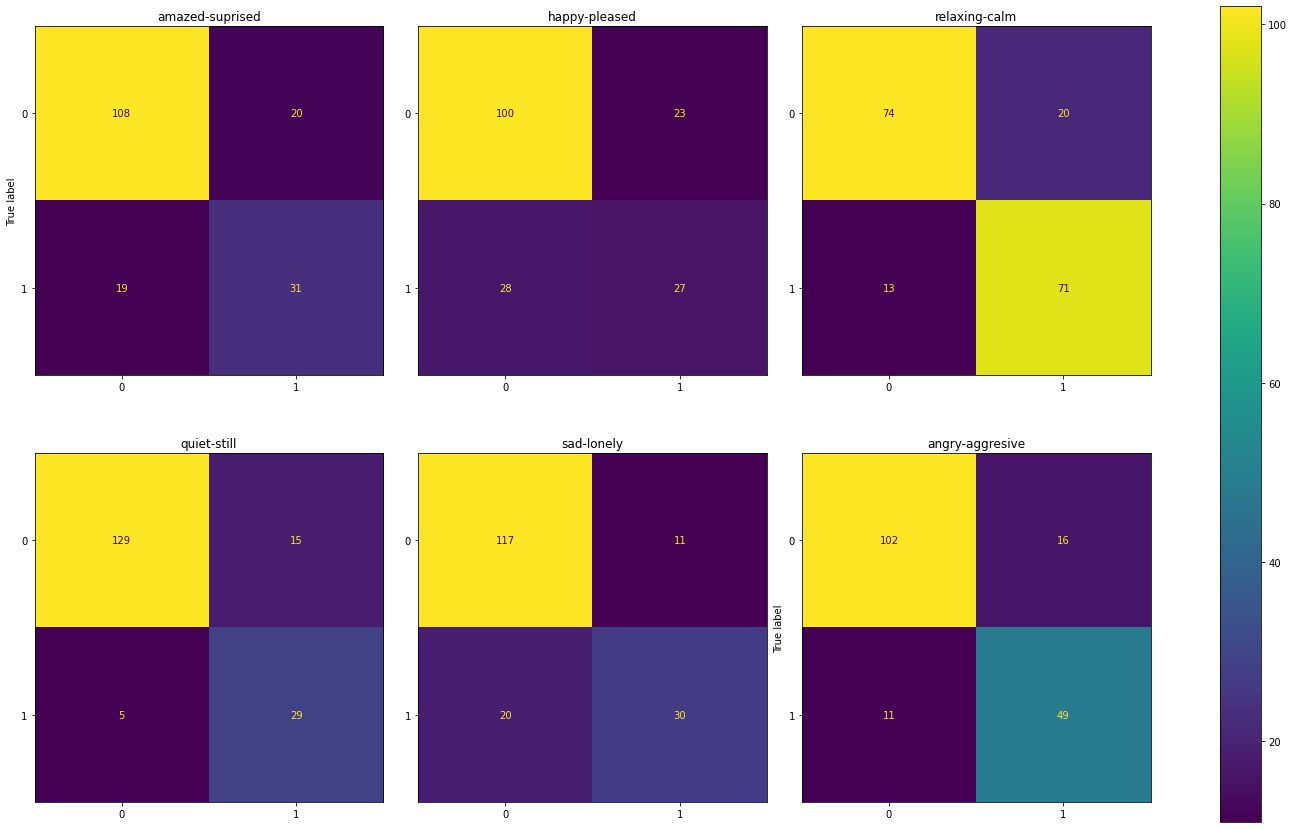

In [26]:

cla_LPowerset = LabelPowerset(ExtraTreesClassifier())
cla_LPowerset.fit(X_train,y_train)
y_pred_LP = cla_LPowerset.predict(X_test) # Predictions on test data

# Matrix de confusion
print('--------------------------------------------------------------------------------------------------------------')   
acc = accuracy_score(y_test,y_pred_LP)
print("ExtraTreesClassifier Accuracy of  = {:.6f} %".format(acc * 100))
f1 = round(f1_score(y_test,y_pred_LP, average = 'micro'),2)  
print("ExtraTreesClassifier F1 Score of  = {:.6f} %".format(f1 * 100))
print('--------------------------------------------------------------------------------------------------------------')   

print(classification_report(y_test,y_pred_LP))    
print('--------------------------------------------------------------------------------------------------------------')   

multilabel_confusion_matrix(y_test, y_pred_LP)
cm = metrics.multilabel_confusion_matrix(y_test, y_pred_LP)
#print(f'Confusion Matrix:\n{cm}')
#print(f'Confusion Matrix:\n{cm[1]}')

f, axes = plt.subplots(2, 3, figsize=(25, 15))
axes = axes.ravel()
for i in range(6):
    disp = ConfusionMatrixDisplay(cm[i])
    disp.plot(ax=axes[i], values_format='.4g')
    #disp.ax_.set_title(f'Label',labels[i])
    disp.ax_.set_title(labels[i])
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

# 3.3 Support Vector Machine

C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


--------------------------------------------------------------------------------------------------------------
Support Vector Machine Accuracy of  = 29.775281 %
Support Vector Machine F1 Score of  = 63.000000 %
--------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.56      0.60      0.58        50
           1       0.40      0.36      0.38        55
           2       0.70      0.76      0.73        84
           3       0.64      0.82      0.72        34
           4       0.64      0.54      0.59        50
           5       0.68      0.73      0.70        60

   micro avg       0.61      0.64      0.63       333
   macro avg       0.60      0.64      0.62       333
weighted avg       0.61      0.64      0.62       333
 samples avg       0.61      0.63      0.60       333

---------------------------------------------------------------------------------

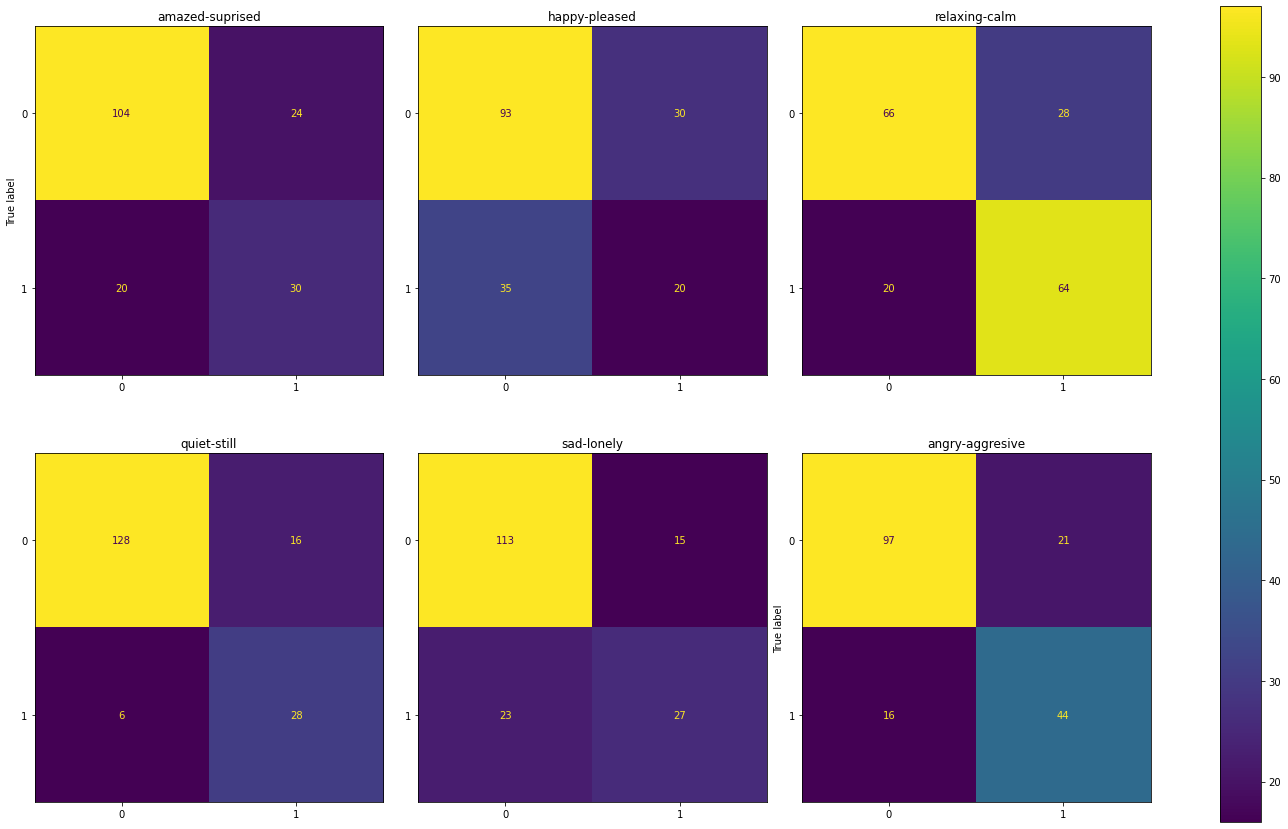

In [27]:

cla_LPowerset = LabelPowerset(svm.SVC(kernel='linear', C = 1.0))
cla_LPowerset.fit(X_train,y_train)
y_pred_LP = cla_LPowerset.predict(X_test) # Predictions on test data

# Matrix de confusion
print('--------------------------------------------------------------------------------------------------------------')   
acc = accuracy_score(y_test,y_pred_LP)
print("Support Vector Machine Accuracy of  = {:.6f} %".format(acc * 100))
f1 = round(f1_score(y_test,y_pred_LP, average = 'micro'),2)  
print("Support Vector Machine F1 Score of  = {:.6f} %".format(f1 * 100))
print('--------------------------------------------------------------------------------------------------------------')   

print(classification_report(y_test,y_pred_LP))    
print('--------------------------------------------------------------------------------------------------------------')   

multilabel_confusion_matrix(y_test, y_pred_LP)
cm = metrics.multilabel_confusion_matrix(y_test, y_pred_LP)
#print(f'Confusion Matrix:\n{cm}')
#print(f'Confusion Matrix:\n{cm[1]}')

f, axes = plt.subplots(2, 3, figsize=(25, 15))
axes = axes.ravel()
for i in range(6):
    disp = ConfusionMatrixDisplay(cm[i])
    disp.plot(ax=axes[i], values_format='.4g')
    #disp.ax_.set_title(f'Label',labels[i])
    disp.ax_.set_title(labels[i])
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

# 3.4 DecisionTreeClassifier

C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


--------------------------------------------------------------------------------------------------------------
DecisionTreeClassifier Accuracy of  = 20.224719 %
DecisionTreeClassifier F1 Score of  = 56.000000 %
--------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.50      0.46      0.48        50
           1       0.45      0.45      0.45        55
           2       0.66      0.68      0.67        84
           3       0.52      0.76      0.62        34
           4       0.51      0.52      0.51        50
           5       0.70      0.50      0.58        60

   micro avg       0.56      0.56      0.56       333
   macro avg       0.56      0.56      0.55       333
weighted avg       0.57      0.56      0.56       333
 samples avg       0.56      0.57      0.54       333

---------------------------------------------------------------------------------

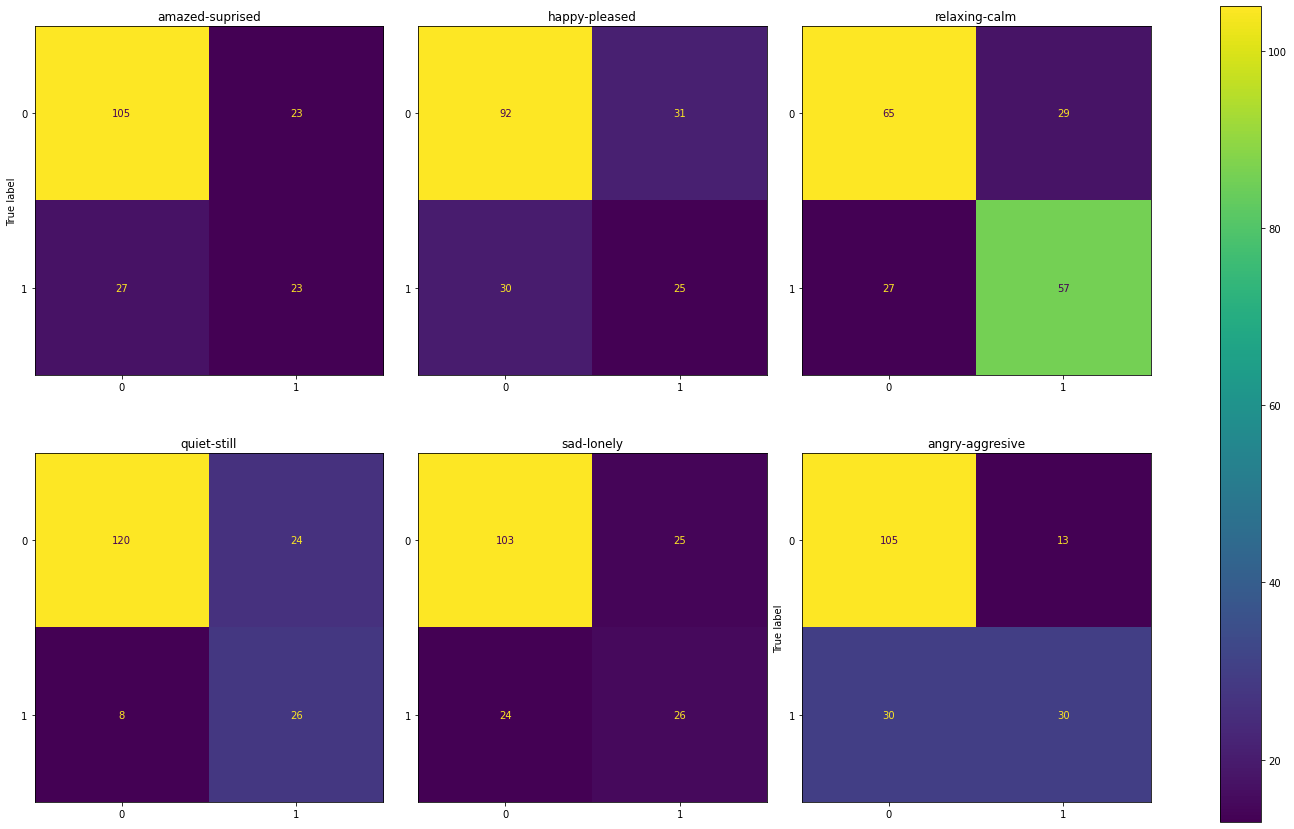

In [28]:

cla_LPowerset = LabelPowerset(DecisionTreeClassifier())
cla_LPowerset.fit(X_train,y_train)
y_pred_LP = cla_LPowerset.predict(X_test) # Predictions on test data

# Matrix de confusion
print('--------------------------------------------------------------------------------------------------------------')   
acc = accuracy_score(y_test,y_pred_LP)
print("DecisionTreeClassifier Accuracy of  = {:.6f} %".format(acc * 100))
f1 = round(f1_score(y_test,y_pred_LP, average = 'micro'),2)  
print("DecisionTreeClassifier F1 Score of  = {:.6f} %".format(f1 * 100))
print('--------------------------------------------------------------------------------------------------------------')   

print(classification_report(y_test,y_pred_LP))    
print('--------------------------------------------------------------------------------------------------------------')   

multilabel_confusion_matrix(y_test, y_pred_LP)
cm = metrics.multilabel_confusion_matrix(y_test, y_pred_LP)
#print(f'Confusion Matrix:\n{cm}')
#print(f'Confusion Matrix:\n{cm[1]}')

f, axes = plt.subplots(2, 3, figsize=(25, 15))
axes = axes.ravel()
for i in range(6):
    disp = ConfusionMatrixDisplay(cm[i])
    disp.plot(ax=axes[i], values_format='.4g')
    #disp.ax_.set_title(f'Label',labels[i])
    disp.ax_.set_title(labels[i])
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

# 3.5 GaussianNB

C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(


--------------------------------------------------------------------------------------------------------------
GaussianNB Accuracy of  = 24.157303 %
GaussianNB F1 Score of  = 60.000000 %
--------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.55      0.54      0.55        50
           1       0.57      0.29      0.39        55
           2       0.74      0.74      0.74        84
           3       0.64      0.82      0.72        34
           4       0.48      0.48      0.48        50
           5       0.77      0.50      0.61        60

   micro avg       0.64      0.56      0.60       333
   macro avg       0.62      0.56      0.58       333
weighted avg       0.64      0.56      0.59       333
 samples avg       0.64      0.58      0.58       333

---------------------------------------------------------------------------------------------------------

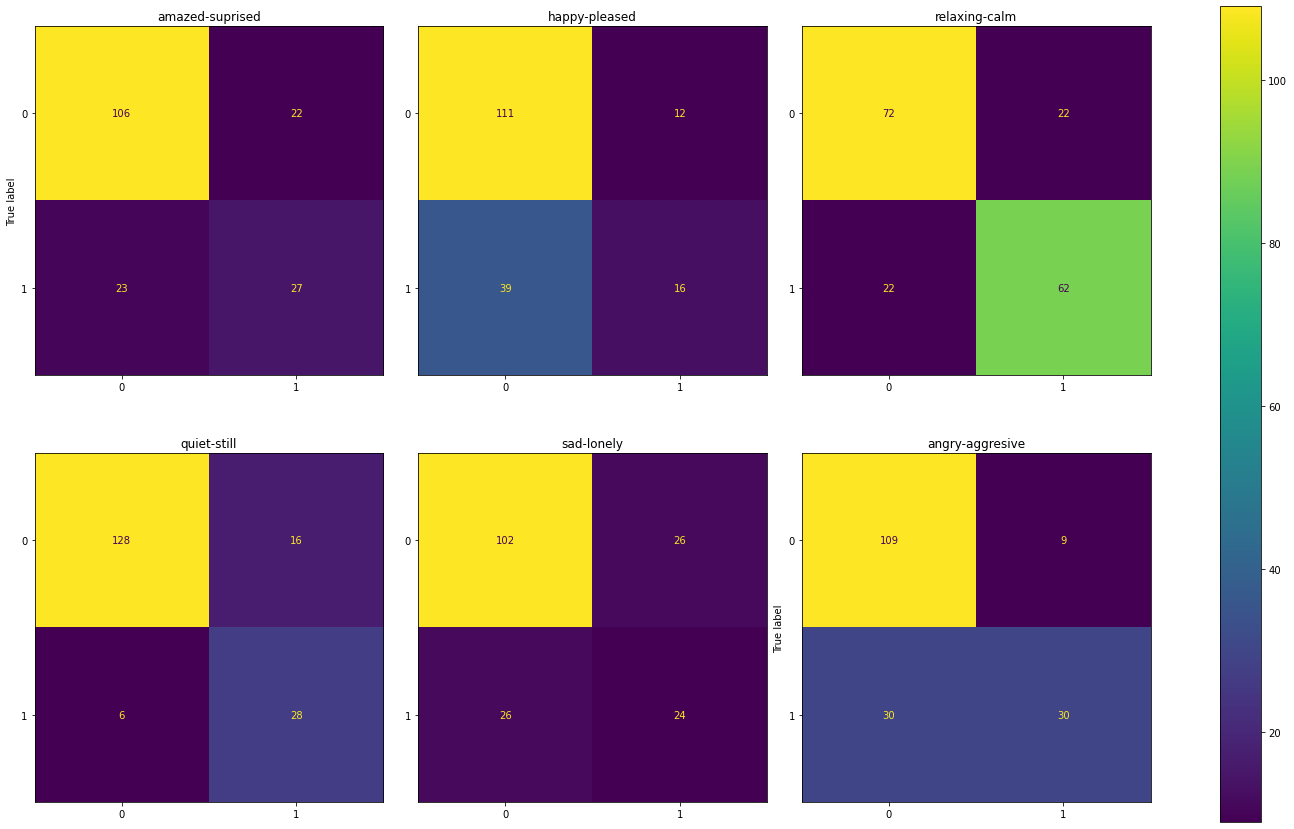

In [29]:

cla_LPowerset = LabelPowerset(GaussianNB())
cla_LPowerset.fit(X_train,y_train)
y_pred_LP = cla_LPowerset.predict(X_test) # Predictions on test data

# Matrix de confusion
print('--------------------------------------------------------------------------------------------------------------')   
acc = accuracy_score(y_test,y_pred_LP)
print("GaussianNB Accuracy of  = {:.6f} %".format(acc * 100))
f1 = round(f1_score(y_test,y_pred_LP, average = 'micro'),2)  
print("GaussianNB F1 Score of  = {:.6f} %".format(f1 * 100))
print('--------------------------------------------------------------------------------------------------------------')   

print(classification_report(y_test,y_pred_LP))    
print('--------------------------------------------------------------------------------------------------------------')   

multilabel_confusion_matrix(y_test, y_pred_LP)
cm = metrics.multilabel_confusion_matrix(y_test, y_pred_LP)
#print(f'Confusion Matrix:\n{cm}')
#print(f'Confusion Matrix:\n{cm[1]}')

f, axes = plt.subplots(2, 3, figsize=(25, 15))
axes = axes.ravel()
for i in range(6):
    disp = ConfusionMatrixDisplay(cm[i])
    disp.plot(ax=axes[i], values_format='.4g')
    #disp.ax_.set_title(f'Label',labels[i])
    disp.ax_.set_title(labels[i])
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

# 3.6 RandomForestClassifier

C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


--------------------------------------------------------------------------------------------------------------
RandomForestClassifier Accuracy of  = 37.640449 %
RandomForestClassifier F1 Score of  = 68.000000 %
--------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.64      0.60      0.62        50
           1       0.52      0.49      0.50        55
           2       0.73      0.85      0.78        84
           3       0.71      0.85      0.77        34
           4       0.70      0.56      0.62        50
           5       0.71      0.77      0.74        60

   micro avg       0.68      0.69      0.68       333
   macro avg       0.67      0.69      0.67       333
weighted avg       0.67      0.69      0.68       333
 samples avg       0.69      0.69      0.66       333

---------------------------------------------------------------------------------

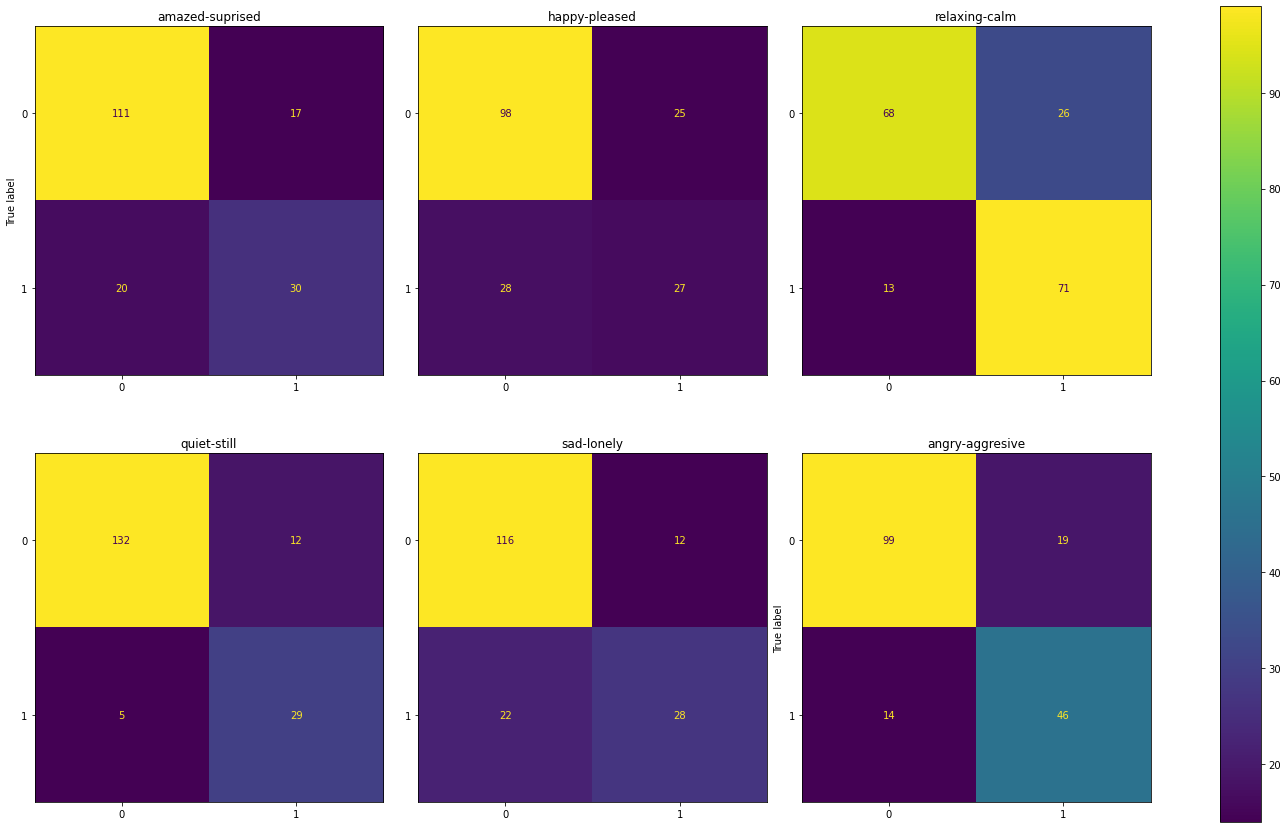

In [30]:

cla_LPowerset = LabelPowerset(RandomForestClassifier())
cla_LPowerset.fit(X_train,y_train)
y_pred_LP = cla_LPowerset.predict(X_test) # Predictions on test data

# Matrix de confusion
print('--------------------------------------------------------------------------------------------------------------')   
acc = accuracy_score(y_test,y_pred_LP)
print("RandomForestClassifier Accuracy of  = {:.6f} %".format(acc * 100))
f1 = round(f1_score(y_test,y_pred_LP, average = 'micro'),2)  
print("RandomForestClassifier F1 Score of  = {:.6f} %".format(f1 * 100))
print('--------------------------------------------------------------------------------------------------------------')   

print(classification_report(y_test,y_pred_LP))    
print('--------------------------------------------------------------------------------------------------------------')   

multilabel_confusion_matrix(y_test, y_pred_LP)
cm = metrics.multilabel_confusion_matrix(y_test, y_pred_LP)
#print(f'Confusion Matrix:\n{cm}')
#print(f'Confusion Matrix:\n{cm[1]}')

f, axes = plt.subplots(2, 3, figsize=(25, 15))
axes = axes.ravel()
for i in range(6):
    disp = ConfusionMatrixDisplay(cm[i])
    disp.plot(ax=axes[i], values_format='.4g')
    #disp.ax_.set_title(f'Label',labels[i])
    disp.ax_.set_title(labels[i])
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()